# Module 6: The CAPM and Linear Factor Models

For this module session, we'll be taking a closer look at the **Capital Asset Pricing Model (CAPM)** and related linear factor models:

1. **Three-Factor Fama-French** model
2. **Four-Factor Fama-French-Carhart** model

We will review several exercises focusing on both the estimation and testing of linear factor models.

As usual, we start by importing all of the necessary Python packages/libraries. 

In [159]:
### Imports: from Python 3.7
from __future__ import division, print_function

### Imports: pandas', 'numpy'
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from pandas.plotting import register_matplotlib_converters

### Imports: check pandas version and import correct web reader
from distutils.version import StrictVersion
if StrictVersion(pd.__version__) >= StrictVersion('0.19'):
    import pandas_datareader.data as web
else:
    import pandas.io.data as web

### Imports: 'statsmodels'
import statsmodels.api as sm

### Imports: 'numba'
import numba
from numba import njit

### Imports: 'scipy'
import scipy
from scipy.optimize import minimize
from scipy.stats import norm, chi2

### Imports: Plotting libraries 'matplotlib' & 'seaborn'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn.apionly as sns

### Imports: Date-related libraries 'datetime', 'calendar'
import datetime as dt
from datetime import date, timedelta

### Imports: other
from cycler import cycler
from IPython.display import display, HTML
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    CSS = """.output {vertical-align: middle;}"""

    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
        '<style>{}</style>'.format(CSS)
    )
from ipy_table import*


### Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

### Figure configurations
fsize = (10,8) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

### This allows plots to appear directly in the notebook
%matplotlib inline    

# Exercise 1 (Setup):

Let's download the following datasets from [Ken French's website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html):

1. [**Fama/French 5 Factors (2x3)**](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html): Fama-French factors (Mkt-RF,     SMB,     HML,     RMW,     CMA,      RF)
2. [**Momentum Factor (Mom)**](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html) Fama-French momentum factor (MOM)
3. [**25 Portfolios Formed on Size and Momentum (5 x 5)**](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_25_port_form_sz_pr_12_2.html): 25 size/momentum portfolios
4. [**25 Portfolios Formed on Size and Book-to-Market (5 x 5)**](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/tw_5_ports.html): 25 size/book-to-market portfolios

The $4th$ dataset was analyzed in lecture and will be used to verify that any functions/routines we write and use for the $3rd$ dataset are correct.

The portfolios are described in detail on Kenneth French's website.  For the following exercise, we will use <u>monthly data</u> from **July 1963** to **March 2019**. Moreover, we will use **value-weighted** size/momentum (or size/book-to-market) portfolios as test assets.

For time-series regressions, we will calculate **OLS**, **White** and **Newey-West** standard errors using the `statsmodels` package.

We can pull the data remotely using the `pandas-datareader` package. Specifically we use the [`DataReader`](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-ff) function, which gives us access to the entire Ken French library. It is important to pass the arguments `start` and `end` dates as `datetime` objects so we pull data for a given sample period. 

Recall that you can obtain documentation for functions as part of a package/library by using the `?` symbol:

In [ ]:
?web.DataReader

In [ ]:
To get a list of all available datasets, we use the function `get_available_datasets`:

In [2]:
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets() 

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portfolios_ME_OP_5x5_Wout_Div',
 '25_Portfolios_ME_OP_5x5_daily',
 '100_Po

Each dataset pull is provided as a `dict` object of `DataFrames` with a description that can be accessed via the key `DESCR`. Depending on the dataset pull, `DataFrames` will include monthly or annual data, value-weighted or equal-weighted portfolios, etc.

In [4]:
### =True if accessing data remotely.
access_ff = False

if access_ff:
    ### Specify the start and end dates, else the default pull only grabs data beginning in 2010.
    dt_start = dt.datetime(1927, 1, 31)

    ### 1a. Fama-French factors (Mkt-RF, SMB, HML, RMW, CMA, RF)
    ff_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start=dt_start)
    print("Original datatype:", type(ff_factors), "\n") 
    print(ff_factors['DESCR'], '\n\n')

    #--> keep "monthly" data; ignore "annual" data
    ff5_m_full = ff_factors[0]  
    ff5_m_full.index = ff5_m_full.index.to_timestamp(freq='M')
    print(ff5_m_full.index)
    
    ### Save file to .csv
    ff5_m_full.to_csv('clean_F-F_Research_Data_5_Factors_2x3.csv')
else:
    ff5_m_full = pd.read_csv('clean_F-F_Research_Data_5_Factors_2x3.csv', index_col=['Date'])
    ff5_m_full.index = pd.to_datetime(ff5_m_full.index) + MonthEnd(0)
    print(ff5_m_full.index)

print(ff5_m_full.info(), '\n')
multi_table([ff5_m_full.head(), ff5_m_full.tail()])

DatetimeIndex(['1963-07-31', '1963-08-31', '1963-09-30', '1963-10-31',
               '1963-11-30', '1963-12-31', '1964-01-31', '1964-02-29',
               '1964-03-31', '1964-04-30',
               ...
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='Date', length=669, freq='M')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 669 entries, 1963-07-31 to 2019-03-31
Freq: M
Data columns (total 6 columns):
Mkt-RF    669 non-null float64
SMB       669 non-null float64
HML       669 non-null float64
RMW       669 non-null float64
CMA       669 non-null float64
RF        669 non-null float64
dtypes: float64(6)
memory usage: 36.6 KB
None 



,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-31,-0.39,-0.47,-0.83,0.66,-1.15,0.27
1963-08-31,5.07,-0.79,1.67,0.39,-0.40,0.25
1963-09-30,-1.57,-0.48,0.18,-0.76,0.24,0.27
1963-10-31,2.53,-1.29,-0.10,2.75,-2.24,0.29
1963-11-30,-0.85,-0.84,1.71,-0.45,2.22,0.27
,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2018-11-30,1.69,-0.81,0.20,-0.63,0.42,0.18
2018-12-31,-9.55,-3.00,-1.51,-0.27,0.10,0.19


In [6]:
### =True if accessing data remotely.
access_ff = False

if access_ff:
    ### Specify the start and end dates, else the default pull only grabs data beginning in 2010.
    dt_start = dt.datetime(1927, 1, 31)

    ### 1b. Fama-French factors (Mkt-RF, SMB, HML, RF)
    ff_factors = web.DataReader('F-F_Research_Data_Factors','famafrench', start=dt_start)
    print("Original datatype:", type(ff_factors), "\n") 
    print(ff_factors['DESCR'], '\n\n')

    #--> keep "monthly" data; ignore "annual" data
    ff3_m_full = ff_factors[0] 
    ff3_m_full.index = ff3_m_full.index.to_timestamp(freq='M')
    print(ff3_m_full.index)
    
    ### Save file to .csv
    ff3_m_full.to_csv('clean_F-F_Research_Data_Factors.csv')
else:
    ff3_m_full = pd.read_csv('clean_F-F_Research_Data_Factors.csv', index_col=['Date'])
    ff3_m_full.index = pd.to_datetime(ff3_m_full.index) + MonthEnd(0) 
    print(ff3_m_full.index)

print(ff3_m_full.info(), '\n')
multi_table([ff3_m_full.head(), ff3_m_full.tail()])

DatetimeIndex(['1927-01-31', '1927-02-28', '1927-03-31', '1927-04-30',
               '1927-05-31', '1927-06-30', '1927-07-31', '1927-08-31',
               '1927-09-30', '1927-10-31',
               ...
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='Date', length=1107, freq='M')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1107 entries, 1927-01-31 to 2019-03-31
Freq: M
Data columns (total 4 columns):
Mkt-RF    1107 non-null float64
SMB       1107 non-null float64
HML       1107 non-null float64
RF        1107 non-null float64
dtypes: float64(4)
memory usage: 43.2 KB
None 



,Mkt-RF,SMB,HML,RF
Date,,,,
1927-01-31,-0.06,-0.56,4.83,0.25
1927-02-28,4.18,-0.10,3.17,0.26
1927-03-31,0.13,-1.60,-2.67,0.30
1927-04-30,0.46,0.43,0.60,0.25
1927-05-31,5.44,1.41,4.93,0.30
,Mkt-RF,SMB,HML,RF
Date,,,,
2018-11-30,1.69,-0.78,0.20,0.18
2018-12-31,-9.55,-2.58,-1.51,0.19


In [8]:
### =True if accessing data remotely.
access_ff = False

if access_ff:
    ### Specify the start and end dates, else the default pull only grabs data beginning in 2010.
    dt_start = dt.datetime(1927, 1, 31)

    ### 2. Fama-French momentum factor (MOM)
    ff_factors = web.DataReader('F-F_Momentum_Factor','famafrench', start=dt_start)
    print("Original datatype:", type(ff_factors), '\n') 
    print(ff_factors['DESCR'], '\n\n')

    #--> keep "monthly" data; ignore "annual" data
    ffmom_m_full = ff_factors[0] 
    ffmom_m_full.index = ffmom_m_full.index.to_timestamp(freq='M')
    ffmom_m_full.columns = ffmom_m_full.columns.str.replace(' ', '').str.upper()
    print(ffmom_m_full.index)
    
    ### Save file to .csv
    ffmom_m_full.to_csv('clean_F-F_Momentum_Factor.csv')
else:
    ffmom_m_full = pd.read_csv('clean_F-F_Momentum_Factor.csv', index_col=['Date'])
    ffmom_m_full.index = pd.to_datetime(ffmom_m_full.index) + MonthEnd(0)  
    print(ffmom_m_full.index)

print(ffmom_m_full.info(), '\n')
multi_table([ffmom_m_full.head(), ffmom_m_full.tail()])

DatetimeIndex(['1927-01-31', '1927-02-28', '1927-03-31', '1927-04-30',
               '1927-05-31', '1927-06-30', '1927-07-31', '1927-08-31',
               '1927-09-30', '1927-10-31',
               ...
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='Date', length=1107, freq='M')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1107 entries, 1927-01-31 to 2019-03-31
Freq: M
Data columns (total 1 columns):
MOM    1107 non-null float64
dtypes: float64(1)
memory usage: 17.3 KB
None 



,MOM
Date,
1927-01-31,0.44
1927-02-28,-2.01
1927-03-31,3.59
1927-04-30,4.19
1927-05-31,3.01
,MOM
Date,
2018-11-30,-1.40
2018-12-31,1.73


In [10]:
### =True if accessing data remotely.
access_ff = False

if access_ff:
    ### Specify the start and end dates, else the default pull only grabs data beginning in 2010.
    dt_start = dt.datetime(1927, 1, 31)

    ### 3. 25 Portfolios Formed on Size and Momentum (5 x 5): 25 size/momentum portfolios
    ff_SIZE_MOM = web.DataReader('25_Portfolios_ME_Prior_12_2','famafrench', start=dt_start)
    print("Original datatype:", type(ff_SIZE_MOM), '\n') 
    print(ff_SIZE_MOM['DESCR'], '\n\n')
    
    #--> keep value-weighted "monthly" portfolio data; ignore all other datasets
    ff_SIZE_MOM_m_full = ff_SIZE_MOM[0] 
    ff_SIZE_MOM_m_full.index = ff_SIZE_MOM_m_full.index.to_timestamp(freq='M')
    print(ff_SIZE_MOM_m_full.index)
    
    ### Save file to .csv
    ff_SIZE_MOM_m_full.to_csv('clean_25_Portfolios_ME_Prior_12_2.csv')
else:
    ff_SIZE_MOM_m_full = pd.read_csv('clean_25_Portfolios_ME_Prior_12_2.csv', index_col=['Date'])
    ff_SIZE_MOM_m_full.index = pd.to_datetime(ff_SIZE_MOM_m_full.index) + MonthEnd(0)  
    print(ff_SIZE_MOM_m_full.index)


DatetimeIndex(['1927-01-31', '1927-02-28', '1927-03-31', '1927-04-30',
               '1927-05-31', '1927-06-30', '1927-07-31', '1927-08-31',
               '1927-09-30', '1927-10-31',
               ...
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='Date', length=1107, freq='M')


In [11]:
print(ff_SIZE_MOM_m_full.info())
display(ff_SIZE_MOM_m_full.head())
display(ff_SIZE_MOM_m_full.tail())  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1107 entries, 1927-01-31 to 2019-03-31
Freq: M
Data columns (total 25 columns):
SMALL LoPRIOR    1107 non-null float64
ME1 PRIOR2       1107 non-null float64
ME1 PRIOR3       1107 non-null float64
ME1 PRIOR4       1107 non-null float64
SMALL HiPRIOR    1107 non-null float64
ME2 PRIOR1       1107 non-null float64
ME2 PRIOR2       1107 non-null float64
ME2 PRIOR3       1107 non-null float64
ME2 PRIOR4       1107 non-null float64
ME2 PRIOR5       1107 non-null float64
ME3 PRIOR1       1107 non-null float64
ME3 PRIOR2       1107 non-null float64
ME3 PRIOR3       1107 non-null float64
ME3 PRIOR4       1107 non-null float64
ME3 PRIOR5       1107 non-null float64
ME4 PRIOR1       1107 non-null float64
ME4 PRIOR2       1107 non-null float64
ME4 PRIOR3       1107 non-null float64
ME4 PRIOR4       1107 non-null float64
ME4 PRIOR5       1107 non-null float64
BIG LoPRIOR      1107 non-null float64
ME5 PRIOR2       1107 non-null float64
ME5 PRIOR

,SMALL LoPRIOR,ME1 PRIOR2,ME1 PRIOR3,ME1 PRIOR4,SMALL HiPRIOR,ME2 PRIOR1,ME2 PRIOR2,ME2 PRIOR3,ME2 PRIOR4,ME2 PRIOR5,...,ME4 PRIOR1,ME4 PRIOR2,ME4 PRIOR3,ME4 PRIOR4,ME4 PRIOR5,BIG LoPRIOR,ME5 PRIOR2,ME5 PRIOR3,ME5 PRIOR4,BIG HiPRIOR
Date,,,,,,,,,,,,,,,,,,,,,
1927-01-31,-1.78,2.73,4.16,3.22,-4.95,-3.13,10.14,-0.45,1.68,1.44,...,-2.76,2.82,-0.43,2.10,2.87,-6.16,-1.12,0.32,0.38,-0.83
1927-02-28,6.57,5.98,6.34,7.44,8.87,4.92,7.54,5.50,7.21,5.88,...,7.78,13.48,3.52,4.00,5.07,5.42,4.64,3.87,2.87,5.51
1927-03-31,-3.80,2.97,-4.28,-3.70,-1.16,-4.07,-4.81,-0.35,0.28,-0.21,...,-8.72,-5.03,-1.32,-0.05,2.01,3.85,-4.39,-1.41,1.82,3.47
1927-04-30,1.24,-0.75,0.17,7.44,-7.30,-0.73,1.04,-2.07,3.67,7.36,...,-1.61,-2.49,0.87,0.14,1.12,-99.99,-2.00,0.80,0.59,4.11
1927-05-31,3.67,11.70,1.77,12.86,21.88,0.10,3.59,12.66,4.22,6.10,...,4.65,4.09,3.93,8.16,9.68,5.32,3.32,5.81,4.96,6.91


,SMALL LoPRIOR,ME1 PRIOR2,ME1 PRIOR3,ME1 PRIOR4,SMALL HiPRIOR,ME2 PRIOR1,ME2 PRIOR2,ME2 PRIOR3,ME2 PRIOR4,ME2 PRIOR5,...,ME4 PRIOR1,ME4 PRIOR2,ME4 PRIOR3,ME4 PRIOR4,ME4 PRIOR5,BIG LoPRIOR,ME5 PRIOR2,ME5 PRIOR3,ME5 PRIOR4,BIG HiPRIOR
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-30,-1.39,0.02,-0.30,0.34,-3.46,3.68,2.32,0.11,1.16,0.34,...,4.44,3.14,2.05,3.37,0.48,-2.42,2.55,4.54,-0.68,1.88
2018-12-31,-17.98,-12.55,-10.23,-10.48,-12.84,-13.72,-12.85,-12.49,-10.19,-11.99,...,-13.61,-12.25,-9.99,-11.65,-9.15,-9.73,-9.08,-9.91,-8.26,-8.46
2019-01-31,19.25,10.91,7.22,7.22,10.28,20.68,13.42,10.80,9.26,9.31,...,16.21,12.09,11.36,8.65,9.52,18.84,12.38,7.46,6.12,7.39
2019-02-28,7.58,6.85,4.73,5.08,5.33,4.51,6.09,6.61,5.62,4.53,...,6.49,3.69,3.68,5.57,5.66,-0.19,2.49,2.82,2.52,5.03
2019-03-31,-2.98,-3.67,-4.24,-2.88,-0.91,-3.82,-3.50,-3.33,-2.01,-1.15,...,-0.20,-1.73,0.13,1.60,0.38,1.89,-0.63,2.21,2.50,1.90


In [13]:
### =True if accessing data remotely.
access_ff = False

if access_ff:
    ### Specify the start and end dates, else the default pull only grabs data beginning in 2010.
    dt_start = dt.datetime(1927, 1, 31)

    ### 4. 25 Portfolios Formed on Size and Book-to-Market (5 x 5): 25 size/book-to-market portfolios
    ff_SIZE_BM = web.DataReader('25_Portfolios_5x5','famafrench', start=dt_start)
    print("Original datatype:", type(ff_SIZE_BM), '\n') 
    print(ff_SIZE_BM['DESCR'], '\n\n')

    #--> keep value-weighted "monthly" portfolio data; ignore all other datasets
    ff_SIZE_BM_m_full = ff_SIZE_BM[0] 
    ff_SIZE_BM_m_full.index = ff_SIZE_BM_m_full.index.to_timestamp(freq='M')
    print(ff_SIZE_BM_m_full.index)
    
    ### Save file to .csv
    ff_SIZE_BM_m_full.to_csv('clean_25_Portfolios_5x5.csv')
else:
    ff_SIZE_BM_m_full = pd.read_csv('clean_25_Portfolios_5x5.csv', index_col=['Date'])
    ff_SIZE_BM_m_full.index = pd.to_datetime(ff_SIZE_BM_m_full.index) + MonthEnd(0)  
    print(ff_SIZE_BM_m_full.index)


DatetimeIndex(['1927-01-31', '1927-02-28', '1927-03-31', '1927-04-30',
               '1927-05-31', '1927-06-30', '1927-07-31', '1927-08-31',
               '1927-09-30', '1927-10-31',
               ...
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31'],
              dtype='datetime64[ns]', name='Date', length=1107, freq='M')


In [14]:
print(ff_SIZE_BM_m_full.info())
display(ff_SIZE_BM_m_full.head())
display(ff_SIZE_BM_m_full.tail())  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1107 entries, 1927-01-31 to 2019-03-31
Freq: M
Data columns (total 25 columns):
SMALL LoBM    1107 non-null float64
ME1 BM2       1107 non-null float64
ME1 BM3       1107 non-null float64
ME1 BM4       1107 non-null float64
SMALL HiBM    1107 non-null float64
ME2 BM1       1107 non-null float64
ME2 BM2       1107 non-null float64
ME2 BM3       1107 non-null float64
ME2 BM4       1107 non-null float64
ME2 BM5       1107 non-null float64
ME3 BM1       1107 non-null float64
ME3 BM2       1107 non-null float64
ME3 BM3       1107 non-null float64
ME3 BM4       1107 non-null float64
ME3 BM5       1107 non-null float64
ME4 BM1       1107 non-null float64
ME4 BM2       1107 non-null float64
ME4 BM3       1107 non-null float64
ME4 BM4       1107 non-null float64
ME4 BM5       1107 non-null float64
BIG LoBM      1107 non-null float64
ME5 BM2       1107 non-null float64
ME5 BM3       1107 non-null float64
ME5 BM4       1107 non-null float64
BIG

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1927-01-31,0.45,-8.30,-4.79,3.23,2.02,2.56,-4.24,-0.06,-0.67,11.06,...,2.38,1.47,-0.51,0.23,7.31,-0.78,0.33,-0.44,0.55,4.21
1927-02-28,2.49,-0.30,10.97,3.75,10.21,1.96,8.69,7.86,4.45,7.59,...,5.29,4.27,2.35,6.78,11.47,3.45,5.09,3.42,5.13,6.27
1927-03-31,6.40,-1.75,-7.83,-2.37,-3.57,-1.79,-0.52,-2.02,-0.59,-0.55,...,-2.20,0.16,-1.34,-1.39,3.89,0.58,1.98,-0.12,0.48,-3.84
1927-04-30,5.84,7.81,4.02,3.58,6.42,-2.33,-4.95,-0.30,-0.46,4.47,...,-0.26,1.86,-1.01,0.08,5.75,2.70,0.89,-0.30,-0.42,-3.53
1927-05-31,9.01,9.04,1.04,16.37,10.07,7.67,2.45,5.43,8.72,13.45,...,4.85,6.18,3.83,7.17,7.72,5.69,4.68,5.53,5.42,4.78


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-30,-1.70,0.04,-0.50,0.12,-3.53,3.26,2.69,2.52,2.20,0.71,...,3.28,1.87,3.52,-0.26,4.64,0.73,3.30,1.84,2.75,0.52
2018-12-31,-13.17,-13.69,-11.48,-11.34,-12.83,-12.76,-11.65,-11.20,-13.04,-12.20,...,-10.06,-11.38,-10.49,-12.47,-13.09,-8.38,-7.07,-10.54,-10.15,-12.98
2019-01-31,11.39,10.81,10.10,8.47,11.33,10.95,11.83,9.86,10.54,10.60,...,12.00,10.33,10.41,11.43,12.79,8.28,5.96,10.11,6.49,13.29
2019-02-28,6.84,6.08,6.33,5.13,3.79,6.24,6.82,5.74,5.46,0.70,...,6.80,4.98,3.27,1.93,2.81,3.90,2.97,3.11,1.74,1.67
2019-03-31,1.00,-0.29,-2.60,-5.07,-3.46,-0.27,-1.67,-2.73,-6.06,-2.99,...,1.82,1.12,-0.91,-0.46,-2.87,3.33,1.93,-0.16,-0.59,-3.06


The assignment mentions we should pull data from **July 1963** to **March 2019** hence we select data only for this period. We can use time series indexing in `pandas`:

In [17]:
start_date = '1963-07-31'
end_date   = '2019-03-31'

#ff3_m   = ff3_m_full.loc[start_date:end_date,:]
ff5_m   = ff5_m_full.loc[start_date:end_date,:]
ffmom_m = ffmom_m_full.loc[start_date:end_date,:]
ff_SIZE_MOM_m = ff_SIZE_MOM_m_full.loc[start_date:end_date,:]
ff_SIZE_BM_m  = ff_SIZE_BM_m_full.loc[start_date:end_date,:]

Let's create two `DataFrame` objects: one with all the Fama-French factors (including MOM) and the 25 size/momentum portfolios, and also with all the Fama-French factors (including MOM) but with the 25 size/book-to-market portfolios.

We also need the gross return on `Mkt`.

In [18]:
### Concatenate test assets & factors
df_SIZE_MOM = pd.concat([ff5_m, ffmom_m, ff_SIZE_MOM_m], axis=1) 
df_SIZE_BM  = pd.concat([ff5_m, ffmom_m, ff_SIZE_BM_m], axis=1)

df_SIZE_MOM.insert(df_SIZE_MOM.columns.get_loc('SMB'), 'Mkt', df_SIZE_MOM['Mkt-RF'] + df_SIZE_MOM['RF'])
df_SIZE_BM.insert(df_SIZE_BM.columns.get_loc('SMB'), 'Mkt', df_SIZE_BM['Mkt-RF'] + df_SIZE_BM['RF'])

### Print info for "df_SIZE_MOM"
print(df_SIZE_MOM.columns, '\n')
display(df_SIZE_MOM.head())

### Print info for "df_SIZE_MOM"
print('\n\n', df_SIZE_BM.columns, '\n')
display(df_SIZE_BM.head())


Index(['Mkt-RF', 'Mkt', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM',
       'SMALL LoPRIOR', 'ME1 PRIOR2', 'ME1 PRIOR3', 'ME1 PRIOR4',
       'SMALL HiPRIOR', 'ME2 PRIOR1', 'ME2 PRIOR2', 'ME2 PRIOR3', 'ME2 PRIOR4',
       'ME2 PRIOR5', 'ME3 PRIOR1', 'ME3 PRIOR2', 'ME3 PRIOR3', 'ME3 PRIOR4',
       'ME3 PRIOR5', 'ME4 PRIOR1', 'ME4 PRIOR2', 'ME4 PRIOR3', 'ME4 PRIOR4',
       'ME4 PRIOR5', 'BIG LoPRIOR', 'ME5 PRIOR2', 'ME5 PRIOR3', 'ME5 PRIOR4',
       'BIG HiPRIOR'],
      dtype='object') 



,Mkt-RF,Mkt,SMB,HML,RMW,CMA,RF,MOM,SMALL LoPRIOR,ME1 PRIOR2,...,ME4 PRIOR1,ME4 PRIOR2,ME4 PRIOR3,ME4 PRIOR4,ME4 PRIOR5,BIG LoPRIOR,ME5 PRIOR2,ME5 PRIOR3,ME5 PRIOR4,BIG HiPRIOR
Date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,-0.39,-0.12,-0.47,-0.83,0.66,-1.15,0.27,1.00,-0.19,-1.16,...,-2.70,-1.14,-1.13,-1.53,-1.40,-1.39,-0.40,1.03,0.36,-0.07
1963-08-31,5.07,5.32,-0.79,1.67,0.39,-0.40,0.25,1.03,1.98,1.84,...,5.94,4.55,4.97,4.83,7.94,5.92,4.85,5.78,4.31,7.12
1963-09-30,-1.57,-1.30,-0.48,0.18,-0.76,0.24,0.27,0.16,-0.98,-0.97,...,-4.72,-1.61,-2.24,-1.88,-2.20,-2.28,1.51,-1.49,-1.56,-2.62
1963-10-31,2.53,2.82,-1.29,-0.10,2.75,-2.24,0.29,3.14,-0.66,-0.32,...,0.01,0.10,0.84,0.71,3.81,2.56,1.60,3.10,0.94,8.51
1963-11-30,-0.85,-0.58,-0.84,1.71,-0.45,2.22,0.27,-0.75,-2.08,-1.52,...,1.12,-0.41,-1.18,0.11,-0.20,-1.04,1.77,-0.97,-2.16,-0.70




 Index(['Mkt-RF', 'Mkt', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM', 'SMALL LoBM',
       'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'SMALL HiBM', 'ME2 BM1', 'ME2 BM2',
       'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2', 'ME3 BM3',
       'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3', 'ME4 BM4',
       'ME4 BM5', 'BIG LoBM', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4', 'BIG HiBM'],
      dtype='object') 



,Mkt-RF,Mkt,SMB,HML,RMW,CMA,RF,MOM,SMALL LoBM,ME1 BM2,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,-0.39,-0.12,-0.47,-0.83,0.66,-1.15,0.27,1.00,1.12,-0.15,...,-0.85,-1.71,-2.00,-1.67,-1.86,0.14,0.45,1.26,-0.43,-1.10
1963-08-31,5.07,5.32,-0.79,1.67,0.39,-0.40,0.25,1.03,4.24,1.48,...,5.40,4.76,6.21,7.56,5.35,5.77,4.22,4.75,8.14,6.38
1963-09-30,-1.57,-1.30,-0.48,0.18,-0.76,0.24,0.27,0.16,-2.89,0.70,...,-2.69,-2.01,-1.89,-3.58,-1.99,-1.37,-0.77,-0.99,-0.19,-3.50
1963-10-31,2.53,2.82,-1.29,-0.10,2.75,-2.24,0.29,3.14,1.29,-0.65,...,-0.43,0.91,2.35,5.34,0.61,5.33,1.74,-0.28,2.42,0.49
1963-11-30,-0.85,-0.58,-0.84,1.71,-0.45,2.22,0.27,-0.75,-3.38,-4.04,...,-0.86,-0.88,-0.49,1.15,3.54,-1.26,0.98,-1.55,-2.13,1.35


In [ ]:
### In case date format not consistent across portfolios
if type(df_SIZE_MOM.index)==pd.PeriodIndex:
    df_SIZE_MOM.index = df_SIZE_MOM.index.to_timestamp()

if type(df_SIZE_BM.index)==pd.PeriodIndex:
    df_SIZE_BM.index = df_SIZE_BM.index.to_timestamp()  

The column names for our two `DataFrame` objects are specified so that the test assets (i.e. the 25 portfolios) have a space in their column labels, while the factors do not. This makes it easy to separate the **factor returns** from the **test asset returns**.

In [19]:
col_is_SIZE_MOM_port = [' ' in col for col in df_SIZE_MOM.columns]
colidx_is_SIZE_MOM_port = min([i for i, x in enumerate(col_is_SIZE_MOM_port) if x])

col_is_SIZE_BM_port = [' ' in col for col in df_SIZE_BM.columns]
colidx_is_SIZE_BM_port = min([i for i, x in enumerate(col_is_SIZE_BM_port) if x])

We can now construct excess portfolio returns: 
$$
R_{i,t} - R_{f,t}
$$ 

for $i=1,2,3,...,N$, where $N$ will be 25 in either set of portfolio returns. 

In [20]:
### Returns
R_SIZE_MOM = df_SIZE_MOM.iloc[:, colidx_is_SIZE_MOM_port:]
R_SIZE_BM  = df_SIZE_BM.iloc[:, colidx_is_SIZE_BM_port:]

### Excess Returns
Rex_SIZE_MOM = df_SIZE_MOM.iloc[:, colidx_is_SIZE_MOM_port:].sub(df_SIZE_MOM['RF'], axis=0)
Rex_SIZE_BM  = df_SIZE_BM.iloc[:, colidx_is_SIZE_BM_port:].sub(df_SIZE_BM['RF'], axis=0)

def portfolios_splits(l, n, formed_port=''):
    """
    Yield successive n-sized portfolio name splits from l.
    """
    for i in range(0, len(l), n):
        print(formed_port, 'Portfolios:', l[i:i + n].values)

In [21]:
portfolios_splits(Rex_SIZE_MOM.columns, 5, formed_port='25 size/momentum')
print()
portfolios_splits(Rex_SIZE_BM.columns, 5, formed_port='25 size/book-to-market')

25 size/momentum Portfolios: ['SMALL LoPRIOR' 'ME1 PRIOR2' 'ME1 PRIOR3' 'ME1 PRIOR4' 'SMALL HiPRIOR']
25 size/momentum Portfolios: ['ME2 PRIOR1' 'ME2 PRIOR2' 'ME2 PRIOR3' 'ME2 PRIOR4' 'ME2 PRIOR5']
25 size/momentum Portfolios: ['ME3 PRIOR1' 'ME3 PRIOR2' 'ME3 PRIOR3' 'ME3 PRIOR4' 'ME3 PRIOR5']
25 size/momentum Portfolios: ['ME4 PRIOR1' 'ME4 PRIOR2' 'ME4 PRIOR3' 'ME4 PRIOR4' 'ME4 PRIOR5']
25 size/momentum Portfolios: ['BIG LoPRIOR' 'ME5 PRIOR2' 'ME5 PRIOR3' 'ME5 PRIOR4' 'BIG HiPRIOR']

25 size/book-to-market Portfolios: ['SMALL LoBM' 'ME1 BM2' 'ME1 BM3' 'ME1 BM4' 'SMALL HiBM']
25 size/book-to-market Portfolios: ['ME2 BM1' 'ME2 BM2' 'ME2 BM3' 'ME2 BM4' 'ME2 BM5']
25 size/book-to-market Portfolios: ['ME3 BM1' 'ME3 BM2' 'ME3 BM3' 'ME3 BM4' 'ME3 BM5']
25 size/book-to-market Portfolios: ['ME4 BM1' 'ME4 BM2' 'ME4 BM3' 'ME4 BM4' 'ME4 BM5']
25 size/book-to-market Portfolios: ['BIG LoBM' 'ME5 BM2' 'ME5 BM3' 'ME5 BM4' 'BIG HiBM']


# Exercise 1:

Let's start with the **25 size/book-to-market portfolios** and run the $CAPM$ regression:
$$
\begin{align*}
    R_{t}^{i}-R_{t}^{f}=\alpha _{i}+\beta _{i}\left( R_{t}^{M}-R_{t}^{f}\right)+\varepsilon _{t}^{i}.
\end{align*}
$$

**Part A:** Report the 25 $\alpha_i$'s and $\beta_i$'s along with their standard errors. Are the $\beta_i$'s precisely estimated?

**Part B:** Are the pricing errors ($\hat{\alpha}_{i}$'s) statistically and economically significant? What do you conclude?

**Part C:** Plot the fitted mean excess returns on the $x$-axis and the average excess returns on the $y$-axis. What does this plot say about the fit of the model?

**Part D:** Compute $t$-tests for the null $H_0: \alpha_i=0$ for each $\alpha_i$ individually.

**Part E:** Compute the **Gibbons, Ross, Shanken (GRS) (1987)** test for the joint null $H_0: \alpha_i=0\;\forall i$.
			  
**Part F:** Plot the theoretical **Capital Market Line (CML)** and the **mean-variance frontier (MVF)** spanned by the 25 portfolios.  How does this figure relate to the regression pricing errors?


Let's define all the functions will be using for this practice question as well as the ones that follow:

The user-defined "wrapper" function below returns $\widehat{\alpha}_i$'s, $\widehat{\beta}_i$'s, standard errors of the $\widehat{\alpha}_i$'s and $\widehat{\beta}_i$'s, as well as may other objects of interest. These other objects of interest include a `DataFrame` object containing all the necessary information needed for most of the inference we'll be doing. It also includes tables to be displayed in our notebook.

In [312]:
def test_linear_factor_model(Rex_test, Rex_test_name, Factors_ret, addcon_ts=True, nw_maxlags=1):
    """
    PARAM: Rex_test is [T x N] 'DataFrame' with excess return of test assets as columns (# of columns = N)
    PARAM: Rex_test_name is 'string' for the name of the test assets used.
    PARAM: Factors_ret is [T x f] 'DataFrame' with excess return factors as columns (# of columns = f)
    PARAM: nw_maxlags is 'int' for # of lags used in Newey-West (1987) HAC-corrected standard errors.
           [default: nw_maxlags=1]   
    """    
    Y  = Rex_test
    XX = Factors_ret
    
    ### Allocate 'DataFrame' tables 
    if Rex_test_name=='SIZE_BM':
        rows_idx = ['SMALL', 'ME2', 'ME3', 'ME4', 'BIG']
        cols_idx = ['LoBM', 'BM2', 'BM3', 'BM4', 'HiBM']
    elif Rex_test_name=='SIZE_MOM':
        rows_idx = ['SMALL', 'ME2', 'ME3', 'ME4', 'BIG']
        cols_idx = ['LoPRIOR', 'PRIOR2', 'PRIOR3', 'PRIOR4', 'HiPRIOR']        
    df_alphas = pd.DataFrame(index=rows_idx, columns=cols_idx)    
    df_betas  = pd.DataFrame(index=rows_idx, columns=pd.MultiIndex.from_product([XX.columns, cols_idx])) 
    
    df_betas_se_ols = pd.DataFrame(index=rows_idx, columns=pd.MultiIndex.from_product([XX.columns, cols_idx])) 
    df_betas_se_r   = pd.DataFrame(index=rows_idx, columns=pd.MultiIndex.from_product([XX.columns, cols_idx])) 
    df_betas_se_nw  = pd.DataFrame(index=rows_idx, columns=pd.MultiIndex.from_product([XX.columns, cols_idx])) 
     
    df_alphas_se_ols = pd.DataFrame(index=rows_idx, columns=cols_idx)     
    df_alphas_se_r   = pd.DataFrame(index=rows_idx, columns=cols_idx)  
    df_alphas_se_nw  = pd.DataFrame(index=rows_idx, columns=cols_idx) 
    df_alphas_ttest_ols = pd.DataFrame(index=rows_idx, columns=cols_idx) 
    df_alphas_ttest_r   = pd.DataFrame(index=rows_idx, columns=cols_idx)  
    df_alphas_ttest_nw  = pd.DataFrame(index=rows_idx, columns=cols_idx) 
    
    df_avgret  = pd.DataFrame(index=rows_idx, columns=cols_idx)      
    df_OLS_results = pd.DataFrame(index=Rex_test.columns, 
                                  columns=['factor_model',
                                           'betas', 'alpha', 'resids', 'ret_avg', 'ret_fitted',
                                           'betas-SEs (OLS)', 'alpha-SEs (OLS)', 'alpha-ttest (OLS)',
                                           'betas-SEs (White)', 'alpha-SEs (White)', 'alpha-ttest (White)',
                                           'betas-SEs (NW)', 'alpha-SEs (NW)', 'alpha-ttest (NW)'])
 
    for i in  Rex_test.columns:
        if addcon_ts:
            df_OLS_results.at[i, 'factor_model'] = sm.OLS(Y[i], sm.add_constant(XX)) 
        else:   
            df_OLS_results.at[i, 'factor_model'] = sm.OLS(Y[i], XX) 

        ### regression model (without corrected SEs)
        ols_model = df_OLS_results.loc[i, 'factor_model'].fit()

        df_OLS_results.at[i, 'betas'] = ols_model.params[1:].values
        df_OLS_results.at[i, 'alpha'] = ols_model.params[0]
        df_OLS_results.at[i, 'betas-SEs (OLS)'] = ols_model.bse[1:].values
        df_OLS_results.at[i, 'alpha-SEs (OLS)'] = ols_model.bse[0]
        df_OLS_results.at[i, 'alpha-ttest (OLS)'] = ols_model.tvalues[0]

        df_OLS_results.at[i, 'resids'] = [ols_model.resid]    
        df_OLS_results.at[i, 'ret_avg'] = Y.loc[:, i].mean()
        df_OLS_results.at[i, 'ret_fitted'] = np.dot(XX, ols_model.params[1:]).mean()

        ### White (het-robust) corrections
        df_OLS_results.at[i, 'betas-SEs (White)'] = ols_model.get_robustcov_results(cov_type='HC0').bse[1:]
        df_OLS_results.at[i, 'alpha-SEs (White)'] = ols_model.get_robustcov_results(cov_type='HC0').bse[0]
        df_OLS_results.at[i, 'alpha-ttest (White)'] = ols_model.get_robustcov_results(cov_type='HC0').tvalues[0]

        ### NW (hac-robust) corrections
        df_OLS_results.at[i, 'betas-SEs (NW)'] = ols_model.get_robustcov_results(cov_type='HAC', maxlags=nw_maxlags).bse[1:]
        df_OLS_results.at[i, 'alpha-SEs (NW)'] = ols_model.get_robustcov_results(cov_type='HAC', maxlags=nw_maxlags).bse[0]
        df_OLS_results.at[i, 'alpha-ttest (NW)'] = ols_model.get_robustcov_results(cov_type='HAC', maxlags=nw_maxlags).tvalues[0]
        
        ### Create tables:
        row, col = i.split()[0], i.split()[1]
        if Rex_test_name=='SIZE_BM':
            if row=='ME1': row = 'SMALL' 
            if row=='ME5': row = 'BIG' 
            if col=='BM1': col = 'LoBM' 
            if col=='BM5': col = 'HiBM' 
        elif Rex_test_name=='SIZE_MOM':      
            if row=='ME1': row = 'SMALL' 
            if row=='ME5': row = 'BIG' 
            if col=='PRIOR1': col = 'LoPRIOR' 
            if col=='PRIOR5': col = 'HiPRIOR' 
        
        for f_idx in range(0, len(Factors_ret.columns)):
            df_betas.at[row, (Factors_ret.columns[f_idx], col)] = df_OLS_results.at[i, 'betas'][f_idx]
            df_betas_se_ols.at[row, (Factors_ret.columns[f_idx], col)] = df_OLS_results.at[i, 'betas-SEs (OLS)'][f_idx]
            df_betas_se_r.at[row, (Factors_ret.columns[f_idx], col)] = df_OLS_results.at[i, 'betas-SEs (White)'][f_idx]
            df_betas_se_nw.at[row, (Factors_ret.columns[f_idx], col)] = df_OLS_results.at[i, 'betas-SEs (NW)'][f_idx]
            
        df_alphas.at[row, col] = df_OLS_results.at[i, 'alpha'] 
        df_alphas_se_ols.at[row, col] = df_OLS_results.at[i, 'alpha-SEs (OLS)'] 
        df_alphas_se_r.at[row, col]   = df_OLS_results.at[i, 'alpha-SEs (White)'] 
        df_alphas_se_nw.at[row, col]  = df_OLS_results.at[i, 'alpha-SEs (NW)'] 
        df_alphas_ttest_ols.at[row, col] = df_OLS_results.at[i, 'alpha-ttest (OLS)'] 
        df_alphas_ttest_r.at[row, col]  = df_OLS_results.at[i, 'alpha-ttest (White)'] 
        df_alphas_ttest_nw.at[row, col] = df_OLS_results.at[i, 'alpha-ttest (NW)']        
        df_avgret.at[row, col] = df_OLS_results.at[i, 'ret_avg'] 
        
    ### Create tables       
    #--> factor betas
    df_betas.columns.set_levels(['$\widehat{\\beta}$: '+f for f in df_betas.columns.levels[0]], 
                                level=0, inplace=True)
    betas_tab = multi_table([df_betas])

    #--> factor betas SEs (OLS)
    df_betas_se_ols.columns.set_levels(['$SE(\widehat{\\beta})_{OLS}$ : '+f for f in df_betas_se_ols.columns.levels[0]], 
                                       level=0, inplace=True)
    betas_se_ols_tab = multi_table([df_betas_se_ols])

    #--> factor betas SEs (White)
    df_betas_se_r.columns.set_levels(['$SE(\widehat{\\beta})_{White}$ : '+f for f in df_betas_se_r.columns.levels[0]], 
                                level=0, inplace=True)
    betas_se_r_tab = multi_table([df_betas_se_r])

    #--> factor betas SEs (NW)   
    beta_se_label = 'SE(\widehat{\\beta})_{NW(' + str(nw_maxlags) + ')}'
    df_betas_se_nw.columns.set_levels(['$'+beta_se_label+'$ : '+f for f in df_betas_se_nw.columns.levels[0]], 
                                      level=0, inplace=True)
    betas_se_nw_tab = multi_table([df_betas_se_nw])

    #--> alphas
    df_alphas = pd.concat([df_alphas], axis=1, keys=['$\widehat{\\alpha}$'])
    alpha_tab = multi_table([df_alphas])  

    #--> alphas SEs (OLS, White, NW)
    alpha_se_label = 'SE(\widehat{\\beta})_{NW(' + str(nw_maxlags) + ')}'
    alpha_ttest_label = 't(\widehat{\\beta})_{NW(' + str(nw_maxlags) + ')}'
    
    df_alphas_se_ols = pd.concat([df_alphas_se_ols], axis=1, keys=['$SE(\widehat{\\alpha})_{OLS}$'])
    df_alphas_se_r   = pd.concat([df_alphas_se_r], axis=1, keys=['$SE(\widehat{\\alpha})_{White}$'])
    df_alphas_se_nw  = pd.concat([df_alphas_se_nw], axis=1, keys=['$'+alpha_se_label+'$'])
    alpha_se_tab = multi_table([df_alphas_se_ols, df_alphas_se_r, df_alphas_se_nw])
    
    #--> alphas t-test (OLS, White, NW)
    df_alphas_ttest_ols = pd.concat([df_alphas_ttest_ols], axis=1, keys=['$t(\widehat{\\alpha})_{OLS}$'])
    df_alphas_ttest_r   = pd.concat([df_alphas_ttest_r], axis=1, keys=['$t(\widehat{\\alpha})_{White}$'])
    df_alphas_ttest_nw  = pd.concat([df_alphas_ttest_nw], axis=1, keys=['$'+alpha_ttest_label+'$'])
    alpha_ttest_tab = multi_table([df_alphas_ttest_ols, df_alphas_ttest_r, df_alphas_ttest_nw])
    
    ### dictionary with all the tables
    tables_dict = {'betas_table': betas_tab, 
                   'SE(betas)-ols_table': betas_se_ols_tab,
                   'SE(betas)-robust_table': betas_se_r_tab, 
                   'SE(betas)-nw_table': betas_se_nw_tab,
                   'alphas_table': alpha_tab,
                   'SE(alphas)-all_table': alpha_se_tab,
                   't(alphas)-all_table': alpha_ttest_tab}
    
    return df_OLS_results, tables_dict, df_avgret

The function `scatter_actual_vs_fitted` plots the fitted mean excess returns on the `x-axis` and the average excess returns on the `y-axis`: 

In [309]:
def scatter_actual_vs_fitted(avg_y_actual, avg_y_fitted, y_labels, factor_model=''):      
    ret_min = min([np.min(avg_y_actual), np.min(avg_y_fitted)]) - 0.2
    ret_max = max([np.max(avg_y_actual), np.max(avg_y_fitted)]) + 0.2

    line_45 = np.linspace(ret_min, ret_max, 100)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))        
    axes.scatter(avg_y_fitted, avg_y_actual, s=75)
    axes.plot(line_45, line_45, color='xkcd:red', linewidth=1, linestyle='dashed')
    axes.set_title('$' + factor_model + '$ factor model', fontsize=22)
    axes.set_xlabel('Fitted (Predicted) Return\n(% per month)', fontsize=20)
    axes.set_ylabel('Actual Return\n(% per month)', fontsize=20)
    axes.set_xlim([ret_min, ret_max])
    axes.set_ylim([ret_min, ret_max])

    for p, p_name in enumerate(y_labels):
        axes.annotate(p_name, (avg_y_fitted[p], avg_y_actual[p]))

    fig.tight_layout()

The function `grs_chi2_test` computes the **Gibbons, Ross, and Shanken (GRS)** (1987) $\chi^2$ test statistic for the joint null hypothesis:

$$
\mathbf{H}_0 : \alpha_1=\alpha_2=...\alpha_N=0
$$

where $N$ is the total number of test assets/portfolios and $\alpha_i$ is the pricing error for test asset $i$'s cross-sectional regression. 

For the **CAPM** model, the $\chi^2$ test statistic is given by 
$$
   T\frac{\left(\widehat{\alpha}^{\prime}\cdot \widehat{\mathbf{\Sigma}}^{-1} \cdot \widehat{\alpha} \right)}    {\left(1 + \widehat{SR}_{M}^{2}\right)} = 
    T\frac{\left(1 + \widehat{SR}_{N}^{2}\right)}{\left(1 + \widehat{SR}_{M}^{2}\right)} - 1
$$

while for the **Three-Factor Fama-French** or **Four-Factor Fama-French-Carhart** models the $\chi^2$ test statistic is given by:
$$
   T\frac{\left(\widehat{\alpha}^{\prime}\cdot \widehat{\mathbf{\Sigma}}^{-1} \cdot \widehat{\alpha} \right)}    {\left(1 + \widehat{\mu}_{F}^{\prime}\cdot \widehat{\mathbf{\Omega}_{F}}^{-1} \cdot \widehat{\mu}_{F}\right)}
$$

In [310]:
def grs_chi2_test(alpha, Factors_ret, xs_resids, factor_model=''):
    """
    PARMA: alpha_hat is [T x 1] 'DataFrame' with pricing errors fro cross-sectional regression of "factor_model"
    PARAM: Factors_ret is [T x f] 'DataFrame' with excess return factors as columns (# of columns = f)
           NOTE: needs to include "Mkt-RF" as a factor!
    PARAM: xs_resids is [T x N] 'DataFrame' with residuals from cross-sectional regressions for each of the 
           N test assets (# of columns = N)
    PARAM: factor_model is 'string' of factor model "name"
    """
    xs_resids = np.vstack(xs_resids)
    dof = xs_resids.shape[0]
    T = xs_resids.shape[1]

    Sigma = np.cov(xs_resids)
    Sigma_inv = np.linalg.inv(Sigma)   
    
    grs_num = np.dot(np.dot(alpha.T, Sigma_inv), alpha)
    
    if 'Mkt-RF' in Factors_ret.columns:
        mu_f = np.mean(Factors_ret, axis=0)
        if Factors_ret.shape[1]==1:
            Omega_f = np.array([[np.var(Factors_ret)]])
        else:   
            Omega_f = np.cov(Factors_ret.T)
        Omega_f_inv = np.linalg.inv(Omega_f)  
        grs_denom = 1 +  np.dot(np.dot(mu_f.T, Omega_f_inv), mu_f)
        
        grs_tstat = T * (grs_num/grs_denom).squeeze()
        grs_pval = 1 - chi2.cdf(grs_tstat, dof)
        
        print('(GRS) chi-squared test statistic: ', round(grs_tstat, 3))
        print('(GRS) p-value: ', round(grs_pval, 3))
        print('\tThe 95% critical value of Chi-squared distribution is:', round(chi2.ppf(0.95, dof), 3))
        if grs_tstat > chi2.ppf(0.95, dof):
            print('\tWe reject the null hypothesis that the pricing errors are jointly zero.\n')
        else:
            print('\tWe fail to reject the null hypothesis that the pricing errors are jointly zero.\n')
    else:
        print('You need to include the Market Risk premium "Mkt-RF" in "Factors_ret"!')

The function `mean_variance_frontier` computes and plots the mean-variance frontier. This "brute-force" approach is similar in spirit to the Python's `pypfopt` package (see [online documentaion](https://pyportfolioopt.readthedocs.io/en/latest/)).

In [306]:
def MVF_wgt(df, annualize=True):   
    if annualize:
        freq = 12
    else:
        freq = 1        
    asset_num = len(list(df))

    ### Average returns
    ret = np.matrix(np.mean(df)).T
    ret_max = np.max(ret)

    ### Target returns on efficient frontier
    targetRet_ls = np.arange(0.01, ret_max*5, 0.005)
    cov = np.matrix(df.cov())

    def wrapper(x, cov):
        x = np.asmatrix(x).T
        return x.T * cov * x

    ### Calculate the weight for each portfolio
    def cal_wgt(target, cov):
        cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1}, \
                {"type": "eq", "fun": lambda x: (np.asmatrix(x) * ret - target)[0,0]})
        init = [0] * asset_num
        solved = minimize(wrapper, init, (cov), constraints=cons)
        return solved.x

    wgt_ls = [cal_wgt(target, cov) for target in targetRet_ls]
    ret_ls = [(np.asmatrix(wgt) * ret)[0,0] * (freq) for wgt in wgt_ls]
    var_ls = [np.sqrt((np.asmatrix(wgt) * cov * np.asmatrix(wgt).T)[0,0] * (freq)) for wgt in wgt_ls]
    return wgt_ls, ret_ls, var_ls


def MVF(df, df_mkt, xlim=None, ylim=None, mvf_p=True, annualize=True, port_labels=False):
    
    if annualize:
        freq = 12
        x__SR_M, y__SR_M = 9.6, 6
        x__SR_N, y__SR_N = 9.6, 14.5
    else:
        freq = 1
        x__SR_M, y__SR_M = 1, 1
        x__SR_N, y__SR_N = 1, 2.5
    
    ret_ls=[]
    var_ls=[]
    name_ls = list(df)
    meanRet = freq*np.mean(df)           #--> annualized mean return
    vol_ls  = (np.sqrt(freq))*np.std(df) #--> annualized volatility
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1)
    if annualize:
        ax.set_xlabel("Volatility ($\sigma$) in % (annualized)")
        ax.set_ylabel("Return in % (annualized)")
    else:   
        ax.set_xlabel("Volatility ($\sigma$) in % (monthly)")
        ax.set_ylabel("Return in % (monthly)")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    if port_labels:
        cmap = plt.get_cmap('brg')
        colors = cmap(np.linspace(0, 1, len(name_ls)))
        for name, ret, vol, col in zip(name_ls, meanRet, vol_ls, colors):
            ax.text(vol, ret, name, size=16, color=col, fontsize=12) 
    else:
        ax.scatter(vol_ls, meanRet, s=40, color='#30a2da')
    
    ### Sharpe-Ratio: Mkt (annualized)
    srmkt = (freq**.5)*(df_mkt['Mkt-RF'].mean()/df_mkt['Mkt-RF'].std())
    
    ax.text((freq**.5)*df_mkt['Mkt-RF'].std(), (freq)*df_mkt['Mkt'].mean(), "Mkt", size=18, color='#e5ae38',
            horizontalalignment='center',verticalalignment='center',weight='bold')
    ax.text(0, (freq)*df_mkt['RF'].mean(), "Rf", size=18, color='#e5ae38',
            horizontalalignment='center',verticalalignment='center',weight='bold')
  
    ax.plot(range(xlim[1] + 5), (freq)*df_mkt['RF'].mean() + np.array(srmkt) * range(xlim[1] + 5), 
            lw=1, color='#e5ae38')
    ax.text(x__SR_M, y__SR_M, '$SR_{M}=$' + str(round(srmkt, 3)), size=16, color='#e5ae38')

    if mvf_p:    
        wgt_ls, ret_ls, var_ls = MVF_wgt(df, annualize=annualize)
        ret_ls = np.array(ret_ls)
        var_ls = np.array(var_ls)
        ax.plot(var_ls, ret_ls)
        sr = np.divide(np.array(ret_ls) - (freq)*df_mkt['RF'].mean(), var_ls)
        srmax = np.max(sr)
        tangm, tangs = ret_ls[np.argmax(sr)], var_ls[np.argmax(sr)]
        
        ### Sharpe-Ratio: Portfolios
        ax.text(x__SR_N, y__SR_N,'$SR_{N}=$' + str(round(srmax, 3)), size=16, color='#30a2da')
        ax.text(tangs, tangm, "TP",size=18, color='#30a2da',
                horizontalalignment='center',verticalalignment='center', weight='bold')
        ax.plot(range(xlim[1] + 5), (freq)*df_mkt['RF'].mean() + np.array(srmax) * range(xlim[1] + 5), 
                lw=1, color='#30a2da') 
    
    plt.tight_layout() 
    return ret_ls, var_ls


## Solution to Exercise 1:

Let's start with the **25 size/book-to-market portfolios** and the factor **Mkt-RF**.

In [298]:
### 'DataFrame' with excess returns of test assets: 25 size/book-to-market portfolios
Rex_test = Rex_SIZE_BM
Rex_test_name = 'SIZE_BM'
Factors_ret = df_SIZE_BM[['Mkt-RF']]


Below are the **annualized** mean, standard deviation, and Sharpe Ratios of the 25 size/book-to-market portfolios:

In [299]:
Rex_stats = pd.DataFrame([12*(Rex_test.mean()), 12**.5*Rex_test.std(), 
                          12**.5*Rex_test.mean()/Rex_test.std()])
Rex_stats.index = ['Mean', 'Std.dev.', 'SR']
Rex_stats.T


,Mean,Std.dev.,SR
SMALL LoBM,3.333,27.214,0.122
ME1 BM2,9.405,23.811,0.395
ME1 BM3,9.354,20.615,0.454
ME1 BM4,11.801,19.613,0.602
SMALL HiBM,12.885,20.680,0.623
ME2 BM1,6.091,24.651,0.247
ME2 BM2,9.236,20.621,0.448
ME2 BM3,10.446,18.720,0.558
ME2 BM4,10.766,18.136,0.594
ME2 BM5,11.532,20.707,0.557


In [313]:
ff1_results_SIZE_BM, ff1_SIZE_BM_tab_dict, df_avgret = test_linear_factor_model(Rex_test=Rex_test, 
                                                                       Rex_test_name=Rex_test_name, 
                                                                       Factors_ret=Factors_ret, 
                                                                       nw_maxlags=12)

In [314]:
#--> average portfolio returns (annualized):
df_avgret  = pd.concat([df_avgret*12], axis=1, keys=['$Avg[R^{e}_{i,t}]$'])
avgret_tab = multi_table([df_avgret])
                        
display(avgret_tab)

### Solution to Exercise 1 (Part A):

In [315]:
display(ff1_SIZE_BM_tab_dict['betas_table'])

display(ff1_SIZE_BM_tab_dict['SE(betas)-ols_table'])
display(ff1_SIZE_BM_tab_dict['SE(betas)-robust_table'])
display(ff1_SIZE_BM_tab_dict['SE(betas)-nw_table'])

In [316]:
display(ff1_SIZE_BM_tab_dict['alphas_table'])

### Solution to Exercise 1 (Part B):

In [317]:
display(ff1_SIZE_BM_tab_dict['SE(alphas)-all_table'])

### Solution to Exercise 1 (Part C):

Below I display actual (average) mean excess returns on the (`y-axis`) vs. fitted mean excess returns on the (`x-axis`).

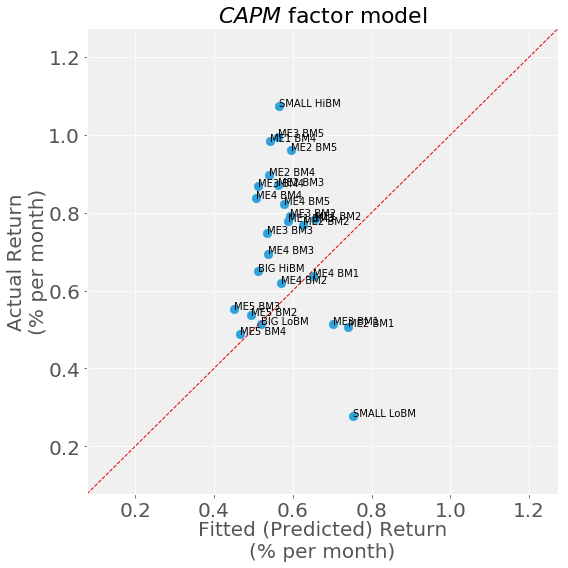

In [318]:
factor_model = 'CAPM'
ret_actual = ff1_results_SIZE_BM['ret_avg']
ret_fitted = ff1_results_SIZE_BM['ret_fitted']
scatter_actual_vs_fitted(avg_y_actual=ret_actual, avg_y_fitted=ret_fitted, 
                         y_labels=ff1_results_SIZE_BM.index, factor_model=factor_model)

### Solution to Exercise 1 (Part D):

In [319]:
display(ff1_SIZE_BM_tab_dict['t(alphas)-all_table'])

### Solution to Exercise 1 (Part E):

In [320]:
Factors_ret = df_SIZE_BM[['Mkt-RF']]

alpha_hat = ff1_results_SIZE_BM['alpha'] 
resids = ff1_results_SIZE_BM['resids']
factor_model ='CAPM'

grs_chi2_test(alpha=alpha_hat, Factors_ret=Factors_ret, xs_resids=resids, factor_model=factor_model)


(GRS) chi-squared test statistic:  117.108
(GRS) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 37.652
	We reject the null hypothesis that the pricing errors are jointly zero.



### Solution to Exercise 1 (Part F):

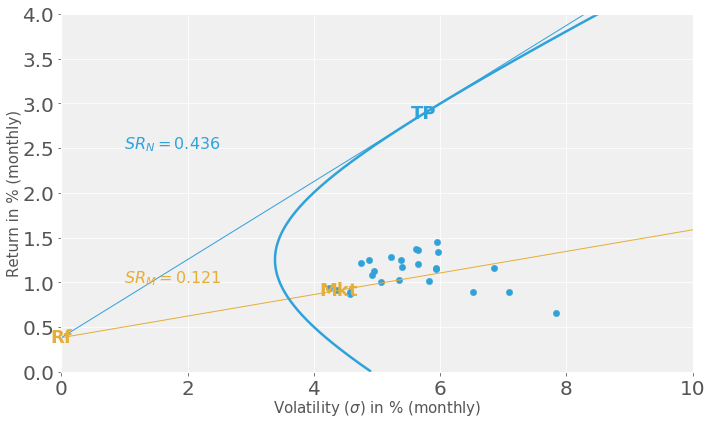

In [37]:
df_mvf = df_SIZE_BM[['Mkt-RF', 'Mkt', 'RF']]
R_test = R_SIZE_BM
r, s = MVF(df=R_test, df_mkt=df_mvf, xlim=[0, 10], ylim=[0, 4], 
           annualize=False, port_labels=False)

# Exercise 2:

Let's start with the **25 size/book-to-market portfolios** and run the **3-Factor Fama-French** regression:

$$
\begin{align*}
    R_{t}^{i}-R_{t}^{f}=\alpha_{i}+\beta_{MKT, i}\left( R_{t}^{M}-R_{t}^{f}\right)
    +\beta_{SMB, i}R_t^{SMB}+\beta_{HML, i}R_t^{HML}+\varepsilon _{t}^{i}.
\end{align*}
$$

**Part A:** Report the 25 $\alpha_i$'s and $\beta_i$'s along with their standard errors. Are the $\beta_i$'s precisely estimated?

**Part B:** Are the pricing errors ($\hat{\alpha}_{i}$'s) statistically and economically significant? What do you conclude?

**Part C:** Plot the fitted mean excess returns on the $x$-axis and the average excess returns on the $y$-axis. What does this plot say about the fit of the model?

**Part D:** Compute $t$-tests for the null $H_0: \alpha_i=0$ for each $\alpha_i$ individually.

**Part E:** Compute the **Gibbons, Ross, Shanken (GRS) (1987)** test for the joint null $H_0: \alpha_i=0\;\forall i$.
			  

## Solution to Exercise 2:

Let's start with the **25 size/book-to-market portfolios** and the factor **Mkt-RF, SMB, HML**.

In [321]:
### 'DataFrame' with excess returns of test assets: 25 size/book-to-market portfolios
Rex_test = Rex_SIZE_BM
Rex_test_name = 'SIZE_BM'
Factors_ret = df_SIZE_BM[['Mkt-RF', 'SMB', 'HML']]


Below are the **annualized** mean, standard deviation, and Sharpe Ratios of the 25 size/book-to-market portfolios:

In [322]:
Rex_stats = pd.DataFrame([12*(Rex_test.mean()), 12**.5*Rex_test.std(), 
                          12**.5*Rex_test.mean()/Rex_test.std()])
Rex_stats.index = ['Mean', 'Std.dev.', 'SR']
Rex_stats.T


,Mean,Std.dev.,SR
SMALL LoBM,3.333,27.214,0.122
ME1 BM2,9.405,23.811,0.395
ME1 BM3,9.354,20.615,0.454
ME1 BM4,11.801,19.613,0.602
SMALL HiBM,12.885,20.680,0.623
ME2 BM1,6.091,24.651,0.247
ME2 BM2,9.236,20.621,0.448
ME2 BM3,10.446,18.720,0.558
ME2 BM4,10.766,18.136,0.594
ME2 BM5,11.532,20.707,0.557


In [323]:
ff3_results_SIZE_BM, ff3_SIZE_BM_tab_dict, df_avgret = test_linear_factor_model(Rex_test=Rex_test, 
                                                                       Rex_test_name=Rex_test_name, 
                                                                       Factors_ret=Factors_ret, 
                                                                       nw_maxlags=12)


In [324]:
#--> average portfolio returns (annualized):
df_avgret  = pd.concat([df_avgret*12], axis=1, keys=['$Avg[R^{e}_{i,t}]$'])
avgret_tab = multi_table([df_avgret])
                        
display(avgret_tab)

### Solution to Exercise 2 (Part A):

In [325]:
display(ff3_SIZE_BM_tab_dict['betas_table'])

display(ff3_SIZE_BM_tab_dict['SE(betas)-ols_table'])
display(ff3_SIZE_BM_tab_dict['SE(betas)-robust_table'])
display(ff3_SIZE_BM_tab_dict['SE(betas)-nw_table'])

In [326]:
display(ff3_SIZE_BM_tab_dict['alphas_table'])

### Solution to Exercise 2 (Part B):

In [327]:
display(ff3_SIZE_BM_tab_dict['SE(alphas)-all_table'])



### Solution to Exercise 2  (Part C):

Below I display actual (average) mean excess returns on the (`y-axis`) vs. fitted mean excess returns on the (`x-axis`).

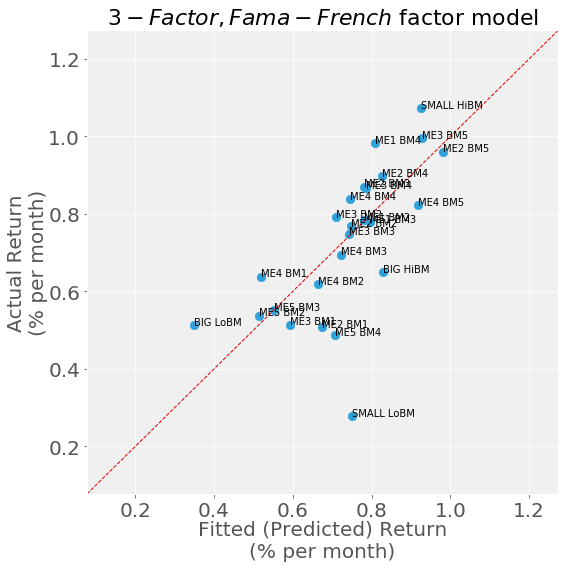

In [328]:
factor_model = '3-Factor, Fama-French'
ret_actual = ff3_results_SIZE_BM['ret_avg']
ret_fitted = ff3_results_SIZE_BM['ret_fitted']
scatter_actual_vs_fitted(avg_y_actual=ret_actual, avg_y_fitted=ret_fitted, 
                         y_labels=ff3_results_SIZE_BM.index, factor_model=factor_model)


### Solution to Exercise 2 (Part D):

In [329]:
display(ff3_SIZE_BM_tab_dict['t(alphas)-all_table'])

### Solution to Exercise 2 (Part E):

In [330]:
Factors_ret = df_SIZE_BM[['Mkt-RF', 'SMB', 'HML']]

alpha_hat = ff3_results_SIZE_BM['alpha'] 
resids = ff3_results_SIZE_BM['resids']
factor_model ='CAPM'

grs_chi2_test(alpha=alpha_hat, Factors_ret=Factors_ret, xs_resids=resids, factor_model=factor_model)


(GRS) chi-squared test statistic:  99.882
(GRS) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 37.652
	We reject the null hypothesis that the pricing errors are jointly zero.



# Exercise 3:

Let's start with the **25 size/momentum portfolios** and run the **CAPM** regression:
$$
\begin{align*}
    R_{t}^{i}-R_{t}^{f}=\alpha_{i}+\beta_{i}\left( R_{t}^{M}-R_{t}^{f}\right)+\varepsilon _{t}^{i}.
\end{align*}
$$

**Part A:** Report the 25 $\alpha_i$'s and $\beta_i$'s along with their standard errors. Are the $\beta_i$'s precisely estimated?

**Part B:** Are the pricing errors ($\hat{\alpha}_{i}$'s) statistically and economically significant? What do you conclude?

**Part C:** Plot the fitted mean excess returns on the $x$-axis and the average excess returns on the $y$-axis. What does this plot say about the fit of the model?

**Part D:** Compute $t$-tests for the null $H_0: \alpha_i=0$ for each $\alpha_i$ individually.

**Part E:** Compute the **Gibbons, Ross, Shanken (GRS) (1987)** test for the joint null $H_0: \alpha_i=0\;\forall i$.
			  
**Part F:** Plot the theoretical **Capital Market Line (CML)** and the **mean-variance frontier (MVF)** spanned by the 25 portfolios.  How does this figure relate to the regression pricing errors?


Let's start with the **25 size/momentum portfolios** and the factor **Mkt-RF**.

In [331]:
### 'DataFrame' with excess returns of test assets: 25 size/momentum portfolios
Rex_test = Rex_SIZE_MOM
Rex_test_name = 'SIZE_MOM'
Factors_ret = df_SIZE_MOM[['Mkt-RF']]


Below are the **annualized** mean, standard deviation, and Sharpe Ratios of the 25 size/book-to-market portfolios:

In [332]:
Rex_stats = pd.DataFrame([12*(Rex_test.mean()), 12**.5*Rex_test.std(), 
                          12**.5*Rex_test.mean()/Rex_test.std()])
Rex_stats.index = ['Mean', 'Std.dev.', 'SR']
Rex_stats.T


,Mean,Std.dev.,SR
SMALL LoPRIOR,0.562,27.602,0.020
ME1 PRIOR2,7.973,20.198,0.395
ME1 PRIOR3,10.960,18.618,0.589
ME1 PRIOR4,12.508,18.754,0.667
SMALL HiPRIOR,15.857,23.146,0.685
ME2 PRIOR1,2.105,26.987,0.078
ME2 PRIOR2,8.249,20.216,0.408
ME2 PRIOR3,9.795,18.089,0.541
ME2 PRIOR4,11.780,18.503,0.637
ME2 PRIOR5,14.286,22.977,0.622


In [333]:
ff1_results_SIZE_MOM, ff1_SIZE_MOM_tables_dict, df_avgret = test_linear_factor_model(Rex_test=Rex_test, 
                                                                       Rex_test_name=Rex_test_name, 
                                                                       Factors_ret=Factors_ret, 
                                                                       nw_maxlags=12)


In [334]:
#--> average portfolio returns (annualized):
df_avgret  = pd.concat([df_avgret*12], axis=1, keys=['$Avg[R^{e}_{i,t}]$'])
avgret_tab = multi_table([df_avgret])
                        
display(avgret_tab)

### Solution to Exercise 3 (Part A):

In [335]:
display(ff1_SIZE_MOM_tables_dict['betas_table'])

display(ff1_SIZE_MOM_tables_dict['SE(betas)-ols_table'])
display(ff1_SIZE_MOM_tables_dict['SE(betas)-robust_table'])
display(ff1_SIZE_MOM_tables_dict['SE(betas)-nw_table'])

In [336]:
display(ff1_SIZE_MOM_tables_dict['alphas_table'])


### Solution to Exercise 3 (Part B):

In [337]:
display(ff1_SIZE_MOM_tables_dict['SE(alphas)-all_table'])


### Solution to Exercise 3 (Part C):

Below I display actual (average) mean excess returns on the (`y-axis`) vs. fitted mean excess returns on the (`x-axis`).

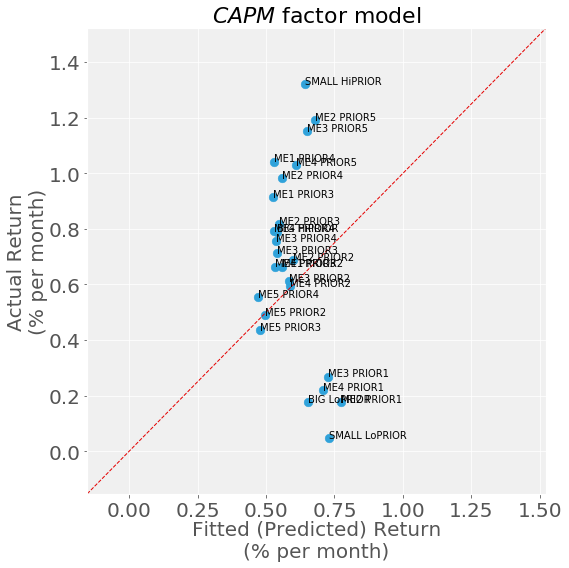

In [338]:
factor_model = 'CAPM'
ret_actual = ff1_results_SIZE_MOM['ret_avg']
ret_fitted = ff1_results_SIZE_MOM['ret_fitted']
scatter_actual_vs_fitted(avg_y_actual=ret_actual, avg_y_fitted=ret_fitted, 
                         y_labels=ff1_results_SIZE_MOM.index, factor_model=factor_model)


### Solution to Exercise 3 (Part D):

In [339]:
display(ff1_SIZE_MOM_tables_dict['t(alphas)-all_table'])


### Solution to Exercise 3 (Part E):

In [340]:
Factors_ret = df_SIZE_MOM[['Mkt-RF']]

alpha_hat = ff1_results_SIZE_MOM['alpha'] 
resids = ff1_results_SIZE_MOM['resids']
factor_model ='CAPM'

grs_chi2_test(alpha=alpha_hat, Factors_ret=Factors_ret, xs_resids=resids, factor_model=factor_model)


(GRS) chi-squared test statistic:  135.769
(GRS) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 37.652
	We reject the null hypothesis that the pricing errors are jointly zero.



### Solution to Exercise 3 (Part F):

We will **annualize** both Returns and Volatility.

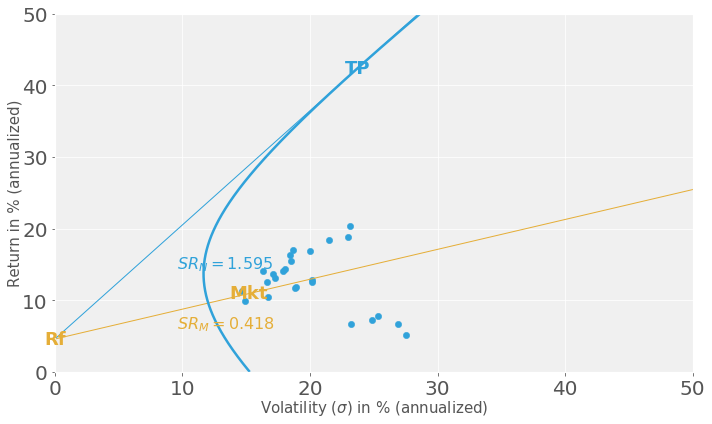

In [58]:
df_mvf = df_SIZE_MOM[['Mkt-RF', 'Mkt', 'RF']]
R_test = R_SIZE_MOM
r, s = MVF(df=R_test, df_mkt=df_mvf, xlim=[0, 50], ylim=[0, 50], annualize=True, port_labels=False)

**Non-annualized:**

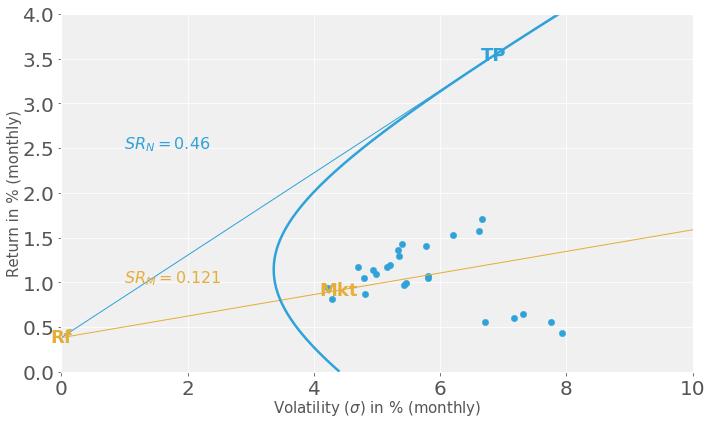

In [59]:
df_mvf = df_SIZE_MOM[['Mkt-RF', 'Mkt', 'RF']]
R_test = R_SIZE_MOM
r, s = MVF(df=R_test, df_mkt=df_mvf, xlim=[0, 10], ylim=[0, 4], annualize=False, port_labels=False)

# Exercise 4:

Let's start with the **25 size/momentum portfolios** and run the **3-Factor Fama-French** regression:

$$
\begin{align*}
    R_{t}^{i}-R_{t}^{f}=\alpha_{i}+\beta_{MKT, i}\left( R_{t}^{M}-R_{t}^{f}\right)
    +\beta_{SMB, i}R_t^{SMB}+\beta_{HML, i}R_t^{HML}+\varepsilon _{t}^{i}.
\end{align*}
$$

**Part A:** Report the 25 $\alpha_i$'s and $\beta_i$'s along with their standard errors. Are the $\beta_i$'s precisely estimated?

**Part B:** Are the pricing errors ($\hat{\alpha}_{i}$'s) statistically and economically significant? What do you conclude?

**Part C:** Plot the fitted mean excess returns on the $x$-axis and the average excess returns on the $y$-axis. What does this plot say about the fit of the model?

**Part D:** Compute $t$-tests for the null $H_0: \alpha_i=0$ for each $\alpha_i$ individually.

**Part E:** Compute the **Gibbons, Ross, Shanken (GRS) (1987)** test for the joint null $H_0: \alpha_i=0\;\forall i$.
			  

Let's start with the **25 size/momentum portfolios** and the factors **Mkt-RF, SMB, HML**.

In [341]:
### 'DataFrame' with excess returns of test assets: 25 size/momentums portfolios
Rex_test = Rex_SIZE_MOM
Rex_test_name = 'SIZE_MOM'
Factors_ret = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML']]


Below are the **annualized** mean, standard deviation, and Sharpe Ratios of the 25 size/momentum portfolios:

In [342]:
Rex_stats = pd.DataFrame([12*(Rex_test.mean()), 12**.5*Rex_test.std(), 
                          12**.5*Rex_test.mean()/Rex_test.std()])
Rex_stats.index = ['Mean', 'Std.dev.', 'SR']
Rex_stats.T


,Mean,Std.dev.,SR
SMALL LoPRIOR,0.562,27.602,0.020
ME1 PRIOR2,7.973,20.198,0.395
ME1 PRIOR3,10.960,18.618,0.589
ME1 PRIOR4,12.508,18.754,0.667
SMALL HiPRIOR,15.857,23.146,0.685
ME2 PRIOR1,2.105,26.987,0.078
ME2 PRIOR2,8.249,20.216,0.408
ME2 PRIOR3,9.795,18.089,0.541
ME2 PRIOR4,11.780,18.503,0.637
ME2 PRIOR5,14.286,22.977,0.622


In [343]:
ff3_results_SIZE_MOM, ff3_SIZE_MOM_tab_dict, df_avgret = test_linear_factor_model(Rex_test=Rex_test, 
                                                                        Rex_test_name=Rex_test_name, 
                                                                        Factors_ret=Factors_ret, 
                                                                        nw_maxlags=12)


In [344]:
#--> average portfolio returns (annualized):
df_avgret  = pd.concat([df_avgret*12], axis=1, keys=['$Avg[R^{e}_i]$'])
avgret_tab = multi_table([df_avgret])
                        
display(avgret_tab)

### Solution to Exercise 4 (Part A):

In [345]:
display(ff3_SIZE_MOM_tab_dict['betas_table'])

display(ff3_SIZE_MOM_tab_dict['SE(betas)-ols_table'])
display(ff3_SIZE_MOM_tab_dict['SE(betas)-robust_table'])
display(ff3_SIZE_MOM_tab_dict['SE(betas)-nw_table'])

In [346]:
display(ff3_SIZE_MOM_tab_dict['alphas_table'])

### Solution to Exercise 4 (Part B):

In [347]:
display(ff3_SIZE_MOM_tab_dict['SE(alphas)-all_table'])

### Solution to Exercise 4 (Part C):

Below I display actual (average) mean excess returns on the (`y-axis`) vs. fitted mean excess returns on the (`x-axis`).

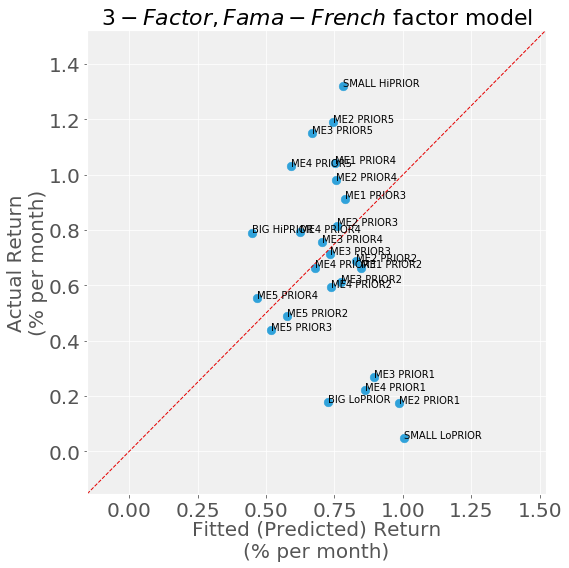

In [348]:
factor_model = '3-Factor, Fama-French'
ret_actual = ff3_results_SIZE_MOM['ret_avg']
ret_fitted = ff3_results_SIZE_MOM['ret_fitted']
scatter_actual_vs_fitted(avg_y_actual=ret_actual, avg_y_fitted=ret_fitted, 
                         y_labels=ff3_results_SIZE_MOM.index, factor_model=factor_model)

### Solution to Exercise 4 (Part D):

In [349]:
display(ff3_SIZE_MOM_tab_dict['t(alphas)-all_table'])

### Solution to Exercise 4 (Part E):

In [350]:
Factors_ret = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML']]

alpha_hat = ff3_results_SIZE_MOM['alpha'] 
resids = ff3_results_SIZE_MOM['resids']
factor_model ='CAPM'

grs_chi2_test(alpha=alpha_hat, Factors_ret=Factors_ret, xs_resids=resids, factor_model=factor_model)

(GRS) chi-squared test statistic:  136.016
(GRS) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 37.652
	We reject the null hypothesis that the pricing errors are jointly zero.



# Exercise 5:

Let's start with the **25 size/momentum portfolios** and run the **4-Factor Fama-French-Carhart** regression:

$$
\begin{align*}
    R_{t}^{i}-R_{t}^{f}=\alpha _{i}+\beta_{MKT, i}\left( R_{t}^{M}-R_{t}^{f}\right)
    +\beta_{SMB, i}R_t^{SMB}+\beta_{HML, i}R_t^{HML}+\beta_{MOM, i}R_t^{MOM}+\varepsilon _{t}^{i}.
\end{align*}
$$

**Part A:** Report the 25 $\alpha_i$'s and $\beta_i$'s along with their standard errors. Are the $\beta_i$'s precisely estimated?

**Part B:** Are the pricing errors ($\hat{\alpha}_{i}$'s) statistically and economically significant? What do you conclude?

**Part C:** Plot the fitted mean excess returns on the $x$-axis and the average excess returns on the $y$-axis. What does this plot say about the fit of the model?

**Part D:** Compute $t$-tests for the null $H_0: \alpha_i=0$ for each $\alpha_i$ individually.

**Part E:** Compute the **Gibbons, Ross, Shanken (GRS) (1987)** test for the joint null $H_0: \alpha_i=0\;\forall i$.
			  

Let's start with the **25 size/momentum portfolios** and the factors **Mkt-RF, SMB, HML, MOM**.

In [351]:
### 'DataFrame' with excess returns of test assets: 25 size/momentums portfolios
Rex_test = Rex_SIZE_MOM
Rex_test_name = 'SIZE_MOM'
Factors_ret = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML', 'MOM']]


Below are the **annualized** mean, standard deviation, and Sharpe Ratios of the 25 size/momentum portfolios:

In [352]:
Rex_stats = pd.DataFrame([12*(Rex_test.mean()), 12**.5*Rex_test.std(), 
                          12**.5*Rex_test.mean()/Rex_test.std()])
Rex_stats.index = ['Mean', 'Std.dev.', 'SR']
Rex_stats.T


,Mean,Std.dev.,SR
SMALL LoPRIOR,0.562,27.602,0.020
ME1 PRIOR2,7.973,20.198,0.395
ME1 PRIOR3,10.960,18.618,0.589
ME1 PRIOR4,12.508,18.754,0.667
SMALL HiPRIOR,15.857,23.146,0.685
ME2 PRIOR1,2.105,26.987,0.078
ME2 PRIOR2,8.249,20.216,0.408
ME2 PRIOR3,9.795,18.089,0.541
ME2 PRIOR4,11.780,18.503,0.637
ME2 PRIOR5,14.286,22.977,0.622


In [353]:
ff4_results_SIZE_MOM, ff4_SIZE_MOM_tab_dict, df_avgret = test_linear_factor_model(Rex_test=Rex_test, 
                                                                        Rex_test_name=Rex_test_name, 
                                                                        Factors_ret=Factors_ret, 
                                                                        nw_maxlags=12)


In [354]:
#--> average portfolio returns (annualized):
df_avgret  = pd.concat([df_avgret*12], axis=1, keys=['$Avg[R^{e}_{i,t}]$'])
avgret_tab = multi_table([df_avgret])
                        
display(avgret_tab)

### Solution to Exercise 5 (Part A):

In [355]:
display(ff4_SIZE_MOM_tab_dict['betas_table'])

display(ff4_SIZE_MOM_tab_dict['SE(betas)-ols_table'])
display(ff4_SIZE_MOM_tab_dict['SE(betas)-robust_table'])
display(ff4_SIZE_MOM_tab_dict['SE(betas)-nw_table'])

In [356]:
display(ff4_SIZE_MOM_tab_dict['alphas_table'])


### Solution to Exercise 5 (Part B):

In [357]:
display(ff4_SIZE_MOM_tab_dict['SE(alphas)-all_table'])


### Solution to Exercise 5 (Part C):

Below I display actual (average) mean excess returns on the (`y-axis`) vs. fitted mean excess returns on the (`x-axis`).

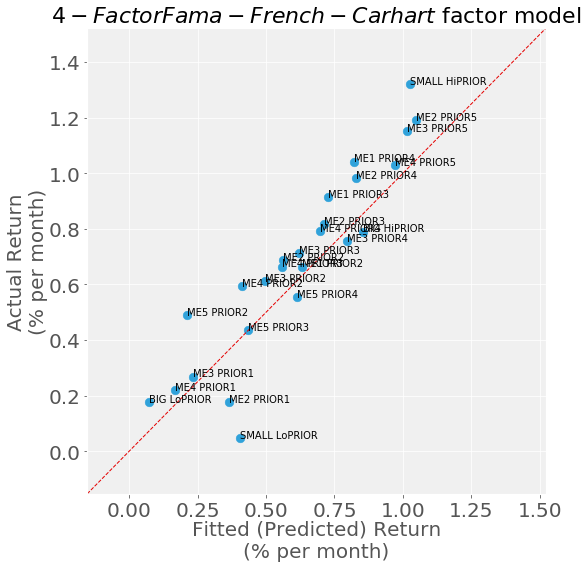

In [358]:
factor_model = '4-Factor Fama-French-Carhart'
ret_actual = ff4_results_SIZE_MOM['ret_avg']
ret_fitted = ff4_results_SIZE_MOM['ret_fitted']
scatter_actual_vs_fitted(avg_y_actual=ret_actual, avg_y_fitted=ret_fitted, 
                         y_labels=ff4_results_SIZE_MOM.index, factor_model=factor_model)

### Solution to Exercise 5 (Part D):

In [359]:
display(ff4_SIZE_MOM_tab_dict['t(alphas)-all_table'])

### Solution to Exercise 5 (Part E):

In [360]:
Factors_ret = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML', 'MOM']]

alpha_hat = ff4_results_SIZE_MOM['alpha'] 
resids = ff4_results_SIZE_MOM['resids']
factor_model ='CAPM'

grs_chi2_test(alpha=alpha_hat, Factors_ret=Factors_ret, xs_resids=resids, factor_model=factor_model)


(GRS) chi-squared test statistic:  102.77
(GRS) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 37.652
	We reject the null hypothesis that the pricing errors are jointly zero.



# Exercise 6:

Estimate the risk premia of the **4-factor** model using a cross-sectional regression. 

Calculate the risk premia for the four factors (i.e. their $\lambda$’s) and the pricing errors (the $\alpha$’s). 

Compute the standard errors of the factor premia assuming that the beta’s in the first stage are known. It is sufficient to run an **OLS** cross-sectional regression and you do not need to run a **GLS** regression for this question. Summarize the regression results.

Recall the well-known two-step estimation procedure for general linear factor models:

### Step 1:
For each asset $i=1,2,...,N$ and factor $j=1,2,...,K$, estimate the **time-series (TS)** regression:

$$
 R_{i,t+1}^{e} = a_i + \beta_{i,1} F_{1, t+1} + ... + \beta_{i,K} F_{K, t+1} +\epsilon_{i,t+1}
$$

Store the $\widehat{\beta}_{i,j}$'s, the average excess returns $\overline{R_{i}^{e}}$, and the time-series of residuals $\{\widehat{\epsilon}_{i,t}\}_{t=1}^{T}$. The $\widehat{\beta}_{i,j}$'s are the **quantities of risk** for factor $j$.

### Step 2:
Estimate the **prices of risk** $\lambda_j$'s for factors $j=1,2,...K$ in the **cross-sectional (XS)** regression:

$$
 \overline{R_{i}^{e}} = \left(\lambda_0\right) + \lambda_1 \widehat{\beta}_{i,1} + ... +  \lambda_K \widehat{\beta}_{i,K} + 
 \alpha_{i}
$$

where the residuals $\widehat{\alpha}_{i}$ from the **XS** regression is the **pricing error** of asset $i$. $\overline{R_{i}^{e}}$ is the time-series average of asset $i$'s excess returns.

Of course, we have the classic **errors-in-variables** problem where the $\widehat{\beta}_{i,j}$'s estimated in the first-step (**TS** regression) and used in the second-step (**XS** regression) have <u>measurement error</u>. 

The uncertainty in the $\widehat{\beta}_{i,j}$'s should be accounted for in the standard errors for the estimated **prices of risk** $\widehat{\lambda}_j$'s. This can be accounted for using the **Shanken-correction**.


## Solution to Exercise 6:

We already implemented the first-stage! Let's now run the second-stage by defining the function `run_xs_regression`.

We will test the function `run_xs_regression` using the **25 size/book-to-market** portfolios and the **3-Factor, Fama-French** model. The function `create_xs_table` creates a nice table displaying our results.


In [365]:
def run_xs_regression(df_betas, df_Re_bar, addcon_xs=True, nw_maxlags=1, summary=0):
    
    df_OLS_results = {}
    if addcon_xs:
        xs_reg = sm.OLS(df_Re_bar, sm.add_constant(df_betas)).fit()
        df_OLS_results['lambdas']  = xs_reg.params[1:].values
        df_OLS_results['lambda-SEs (OLS)'] = xs_reg.bse[1:].values
        df_OLS_results['lambda-SEs (White)'] = xs_reg.get_robustcov_results(cov_type='HC0').bse[1:]
        df_OLS_results['lambda-SEs (NW)'] = xs_reg.get_robustcov_results(cov_type='HAC', maxlags=nw_maxlags).bse[1:]
        
    else:
        xs_reg = sm.OLS(df_Re_bar, df_betas).fit()
        df_OLS_results['lambdas']  = xs_reg.params.values
        df_OLS_results['lambda-SEs (OLS)'] = xs_reg.bse.values
        df_OLS_results['lambda-SEs (White)'] = xs_reg.get_robustcov_results(cov_type='HC0').bse
        df_OLS_results['lambda-SEs (NW)'] = xs_reg.get_robustcov_results(cov_type='HAC', maxlags=nw_maxlags).bse
        
    if summary==1:
        print('\t', xs_reg.summary(), '\n')
        
    ### Store information:   
    df_OLS_results['xs_model'] = xs_reg     
    df_OLS_results['alpha']  = xs_reg.resid
    return df_OLS_results


def create_xs_table(df_OLS_results, factor_prem, col_idx, nw_maxlags): 
    lambda_se_label = 'SE(\widehat{\lambda})_{NW('+str(nw_maxlags)+')}'
    df_xs_summ = pd.DataFrame(index=['$\widehat{\lambda}$',
                                     '$SE(\widehat{\lambda})_{OLS}$',
                                     '$SE(\widehat{\lambda})_{White}$', 
                                     '$'+lambda_se_label+'$', 
                                     'Factor premia'],
                              columns=col_idx)  
         
    for f, f_idx in zip(col_idx, range(0, len(col_idx))):
        df_xs_summ.at['$\widehat{\lambda}$', f] =  df_OLS_results['lambdas'][f_idx]
        df_xs_summ.at['$SE(\widehat{\lambda})_{OLS}$', f] =  df_OLS_results['lambda-SEs (OLS)'][f_idx]
        df_xs_summ.at['$SE(\widehat{\lambda})_{White}$', f] =  df_OLS_results['lambda-SEs (White)'][f_idx]
        df_xs_summ.at['$'+lambda_se_label+'$', f] = df_OLS_results['lambda-SEs (NW)'][f_idx]
        df_xs_summ.at['Factor premia', f] =  factor_prem[f_idx]
        
    return df_xs_summ

**25 size/book-to-market portfolios** and the factors **Mkt-RF, SMB, HML**:

In [371]:
betas_SIZE_BM  = pd.DataFrame(ff3_results_SIZE_BM['betas'].values.tolist(), 
                               columns=['Mkt-RF', 'SMB', 'HML'], 
                               index=ff3_results_SIZE_BM['betas'].index)

avg_Re_SIZE_BM = ff3_results_SIZE_BM['ret_avg'].astype(float)
ff3_factor_prem = df_SIZE_BM[['Mkt-RF', 'SMB', 'HML']].mean().values

### Cross-sectional regressions:
nw_maxlags = 12
ff3_xs_results = run_xs_regression(df_betas=betas_SIZE_BM, df_Re_bar=avg_Re_SIZE_BM, addcon_xs=True, 
                                   nw_maxlags=nw_maxlags, summary=1)
ff3_xs_summ = create_xs_table(df_OLS_results=ff3_xs_results, 
                              factor_prem=ff3_factor_prem, 
                              col_idx=['Mkt-RF', 'SMB', 'HML'], nw_maxlags=nw_maxlags)

    

	                             OLS Regression Results                            
Dep. Variable:                ret_avg   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     13.63
Date:                Mon, 13 May 2019   Prob (F-statistic):           3.71e-05
Time:                        01:08:31   Log-Likelihood:                 19.491
No. Observations:                  25   AIC:                            -30.98
Df Residuals:                      21   BIC:                            -26.11
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2239      0.371      3.295      0

In [373]:
print('Testing the 3-Factor, Fama-French model: XS Regressions\n')
multi_table([ff3_xs_summ])

Testing the 3-Factor, Fama-French model: XS Regressions



,Mkt-RF,SMB,HML
$\widehat{\lambda}$,-0.660,0.196,0.332
$SE(\widehat{\lambda})_{OLS}$,0.356,0.054,0.062
$SE(\widehat{\lambda})_{White}$,0.290,0.060,0.064
$SE(\widehat{\lambda})_{NW(12)}$,0.281,0.053,0.061
Factor premia,0.530,0.240,0.312


Pricing errors $\widehat{\alpha}_i$'s:

In [374]:
ff3_xs_results['alpha']

SMALL LoBM   -0.337
ME1 BM2      -0.011
ME1 BM3      -0.092
ME1 BM4       0.027
SMALL HiBM    0.092
ME2 BM1      -0.002
ME2 BM2       0.037
ME2 BM3       0.034
ME2 BM4       0.010
ME2 BM5       0.050
ME3 BM1       0.048
ME3 BM2       0.107
ME3 BM3      -0.034
ME3 BM4       0.023
ME3 BM5       0.134
ME4 BM1       0.202
ME4 BM2      -0.000
ME4 BM3      -0.012
ME4 BM4       0.061
ME4 BM5       0.059
BIG LoBM      0.089
ME5 BM2      -0.035
ME5 BM3      -0.111
ME5 BM4      -0.245
BIG HiBM     -0.094
dtype: float64

Let's now answer **Exercise 6** using **25 size/momentum** portfolios and the **4-Factor, Fama-French-Carhart** model.

In [376]:
betas_SIZE_MOM  = pd.DataFrame(ff4_results_SIZE_MOM['betas'].values.tolist(), 
                               columns=['Mkt-RF', 'SMB', 'HML', 'MOM'], 
                               index=ff4_results_SIZE_MOM['betas'].index)

avg_Re_SIZE_MOM = ff4_results_SIZE_MOM['ret_avg'].astype(float)
ff4_factor_prem = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML', 'MOM']].mean().values

### Cross-sectional regressions:
nw_maxlags = 12
ff4_xs_results = run_xs_regression(df_betas=betas_SIZE_MOM, df_Re_bar=avg_Re_SIZE_MOM, addcon_xs=True, 
                                   nw_maxlags=nw_maxlags, summary=1)
ff4_xs_summ = create_xs_table(df_OLS_results=ff4_xs_results, 
                              factor_prem=ff4_factor_prem, 
                              col_idx=['Mkt-RF', 'SMB', 'HML', 'MOM'], nw_maxlags=nw_maxlags)
    

	                             OLS Regression Results                            
Dep. Variable:                ret_avg   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     29.77
Date:                Mon, 13 May 2019   Prob (F-statistic):           3.62e-08
Time:                        01:10:09   Log-Likelihood:                 16.334
No. Observations:                  25   AIC:                            -22.67
Df Residuals:                      20   BIC:                            -16.57
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1131      0.708      0.160      0

In [377]:
print('Testing the 4-Factor, Fama-French-Carhart model: XS Regressions\n')
multi_table([ff4_xs_summ])

Testing the 4-Factor, Fama-French-Carhart model: XS Regressions



,Mkt-RF,SMB,HML,MOM
$\widehat{\lambda}$,0.487,0.212,0.554,0.740
$SE(\widehat{\lambda})_{OLS}$,0.649,0.065,0.430,0.075
$SE(\widehat{\lambda})_{White}$,0.730,0.082,0.504,0.084
$SE(\widehat{\lambda})_{NW(12)}$,0.412,0.051,0.370,0.126
Factor premia,0.530,0.240,0.312,0.652


Pricing errors $\widehat{\alpha}_i$'s:

In [378]:
ff4_xs_results['alpha']

SMALL LoPRIOR   -0.330
ME1 PRIOR2      -0.064
ME1 PRIOR3       0.065
ME1 PRIOR4       0.100
SMALL HiPRIOR    0.222
ME2 PRIOR1      -0.146
ME2 PRIOR2       0.056
ME2 PRIOR3      -0.006
ME2 PRIOR4       0.032
ME2 PRIOR5       0.087
ME3 PRIOR1       0.073
ME3 PRIOR2       0.040
ME3 PRIOR3      -0.022
ME3 PRIOR4      -0.179
ME3 PRIOR5       0.069
ME4 PRIOR1       0.070
ME4 PRIOR2       0.105
ME4 PRIOR3      -0.010
ME4 PRIOR4      -0.028
ME4 PRIOR5      -0.023
BIG LoPRIOR      0.114
ME5 PRIOR2       0.210
ME5 PRIOR3      -0.097
ME5 PRIOR4      -0.182
BIG HiPRIOR     -0.159
dtype: float64

# Exercise 7:

Plot $\widehat{\beta}$'s of the four “corner” portfolios estimated from **60-month rolling regressions**. Are the $\widehat{\beta}$'s varying over time?

## Solution to Exercise 7:

To implement rolling regressions, I provide two similar functions: `beta_roll` and `beta_roll_numba`. 
The former combines `NumPy` and `statsmodels` while the latter makes use of `numba jit`, coupled with a direct computation of the OLS estimator (using `np.linalg.lstsq`) and its standard error (**non-robust** and **White (1980) robust**).

`numba` is a *Just-in-time* compiler for python, i.e. whenever you make a call to a python function all or part of your code is converted to machine code *just-in-time* of execution, and it will then run on your native machine code speed. 

To use `numba` we need to use a decorator, the most common ones being `jit` and `njit`.
* For best performance `numba` recommends using the `nopython = True` argument with your `jit` wrapper. This makes sure you don't use the Python interpreter at all, which would otherwise slow things down. Or, you can also use `@njit` too. 

We can test the speed of `beta_roll` and `beta_roll_numba` using the cell magic `%%time`.

In [165]:
def beta_roll(Y0, X0, addcon=True, cov_type='HC0', window=60):
    x0 = np.asarray(X0)
    y0 = np.asarray(Y0)    
    x = [(x0[i:i + window,:]) for i in range(len(y0) - window + 1)]
    y = [(y0[i:i + window]) for i in range(len(y0) - window + 1)]

    if addcon:
        ols_ret = [sm.OLS(y[j], sm.add_constant(x[j])).fit(cov_type=cov_type) for j in range(len(x))]
    else:   
        ols_ret = [sm.OLS(y[j], x[j]).fit(cov_type=cov_type) for j in range(len(x))]
    beta  = np.asarray([ols_ret[j].params for j in range(len(ols_ret))])
    if cov_type=='nonrobust':
        se = np.asarray([ols_ret[j].bse for j in range(len(ols_ret))])
    elif cov_type=='HC0':
        se = np.asarray([ols_ret[j].HC0_se for j in range(len(ols_ret))])
    
    return beta, se, ols_ret


@njit
def beta_roll_numba(y0, x0, cov_type='HC0', addcon=True, window=60):
    if addcon: 
        T = x0.shape[0]
        X0 = np.concatenate((np.ones((T,1)), x0), axis=1)
    else:
        X0 = x0
    N_ests = len(y0) - window + 1
    K_params = X0.shape[1]
    beta = np.empty((N_ests, K_params))
    se = np.empty((N_ests, K_params))
    for i in range(N_ests):
        x, y = X0[i:i + window,:], y0[i:i + window]
        ### betas:
        beta[i, :] = np.linalg.lstsq(x, y)[0]
        
        ### SEs:
        y_hat = np.dot(x, beta[i,:])
        resids = y - y_hat
        sse = np.dot(resids.T, resids)
        sigma2 = sse / (window - K_params)
        xx_inv = np.linalg.inv(np.dot(x.T, x))
        if cov_type=='nonrobust':
            S_inv =  xx_inv*sigma2           
        elif cov_type=='HC0':
            S_inv =  np.dot(np.dot(np.dot(np.dot(xx_inv, x.T), np.diag(resids**2)),x),xx_inv)
        se_i = np.diag(S_inv)**0.5    
        se[i, :] = se_i
        
    return beta, se

In [387]:
def plot_roll_beta(Y0, X0, window, port_name, ylim=(-1.5,2), cov_type='HC0', run_numba=True):    
    if run_numba:
        beta_roll, se_roll   = beta_roll_numba(y0=Y0.values, x0=X0.values, cov_type='HC0', window=window)
    else:        
        beta_roll, se_roll,_ = beta_roll(Y0=Y0, X0=X0, cov_type='HC0', window=window)

    ### Plot alphas    
    fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    axes1.plot(Y0.index[window-1:], beta_roll[:,0])
    axes1.fill_between(x=Y0.index[window-1:], 
                        y1=beta_roll[:,0] - 2*se_roll[:,0], 
                        y2=beta_roll[:,0] + 2*se_roll[:,0], facecolor='blue', alpha=0.1)
    axes1.set_title(port_name + r": $\widehat{\alpha}$", fontsize=15)
    axes1.set_ylim(None)
    axes1.set_xlabel('Years', fontsize=15)
    plt.tight_layout()
    
    ### Drop alphas:
    beta_roll  = beta_roll[:, 1:]
    se_roll    = se_roll[:, 1:]
        
    ### Plot betas    
    fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(18,14))    
    for f_idx in range(0, beta_roll.shape[1]):
            idx_r, idx_c = f_idx//2, np.mod(f_idx, 2) 
            ax = axes2[idx_r, idx_c]
            
            ax.plot(Y0.index[window-1:], beta_roll[:,f_idx])
            ax.fill_between(x=Y0.index[window-1:], 
                            y1=beta_roll[:,f_idx] - 2*se_roll[:,f_idx], 
                            y2=beta_roll[:,f_idx] + 2*se_roll[:,f_idx], facecolor='blue', alpha=0.1)
            ax.set_title(port_name + r": $\widehat{\beta}$ factor " + str(X0.columns[f_idx]), fontsize=20)
            ax.set_ylim(ylim)            
            ax.set_xlabel('Years', fontsize=18)
    
    plt.tight_layout()

In [389]:
Rex_test = Rex_SIZE_MOM
Factors_ret = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML', 'MOM']]
roll_window = 60

### Corner portfolio #1: `SMALL LoPRIOR`

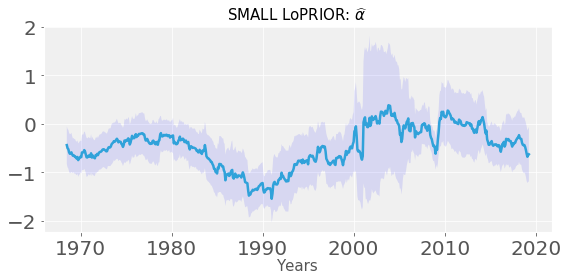

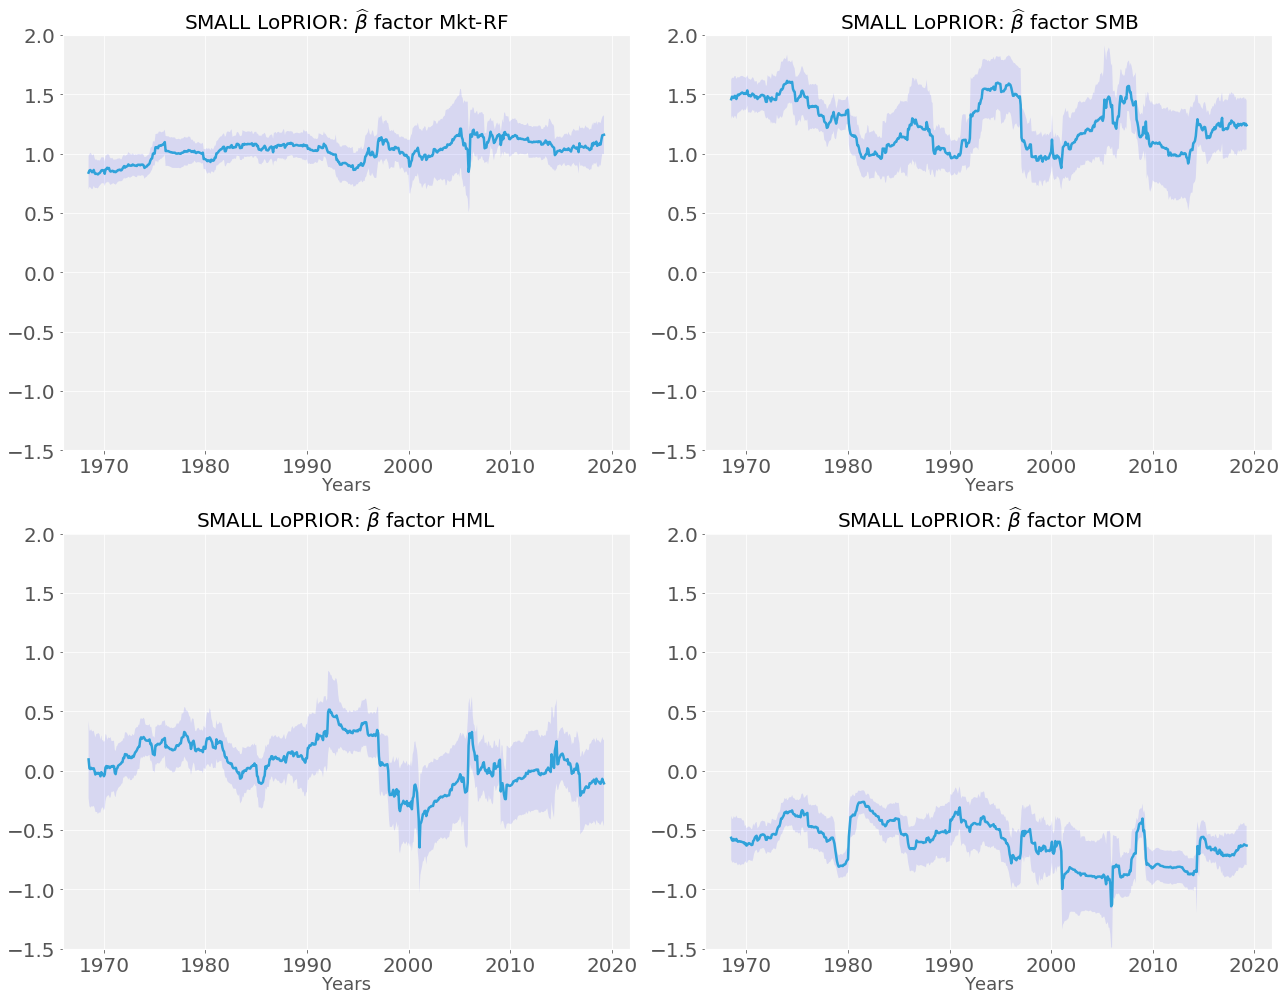

In [390]:
port_name = 'SMALL LoPRIOR'
plot_roll_beta(Y0=Rex_test[port_name], X0=Factors_ret, window=roll_window, cov_type='HC0', 
               port_name=port_name)


### Corner portfolio #2: `SMALL HiPRIOR`

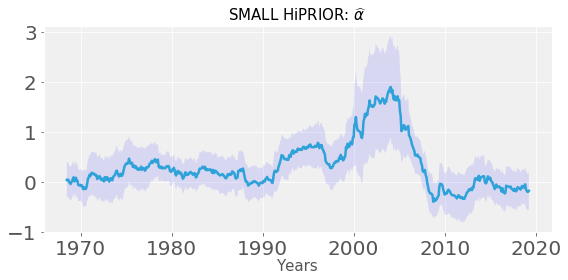

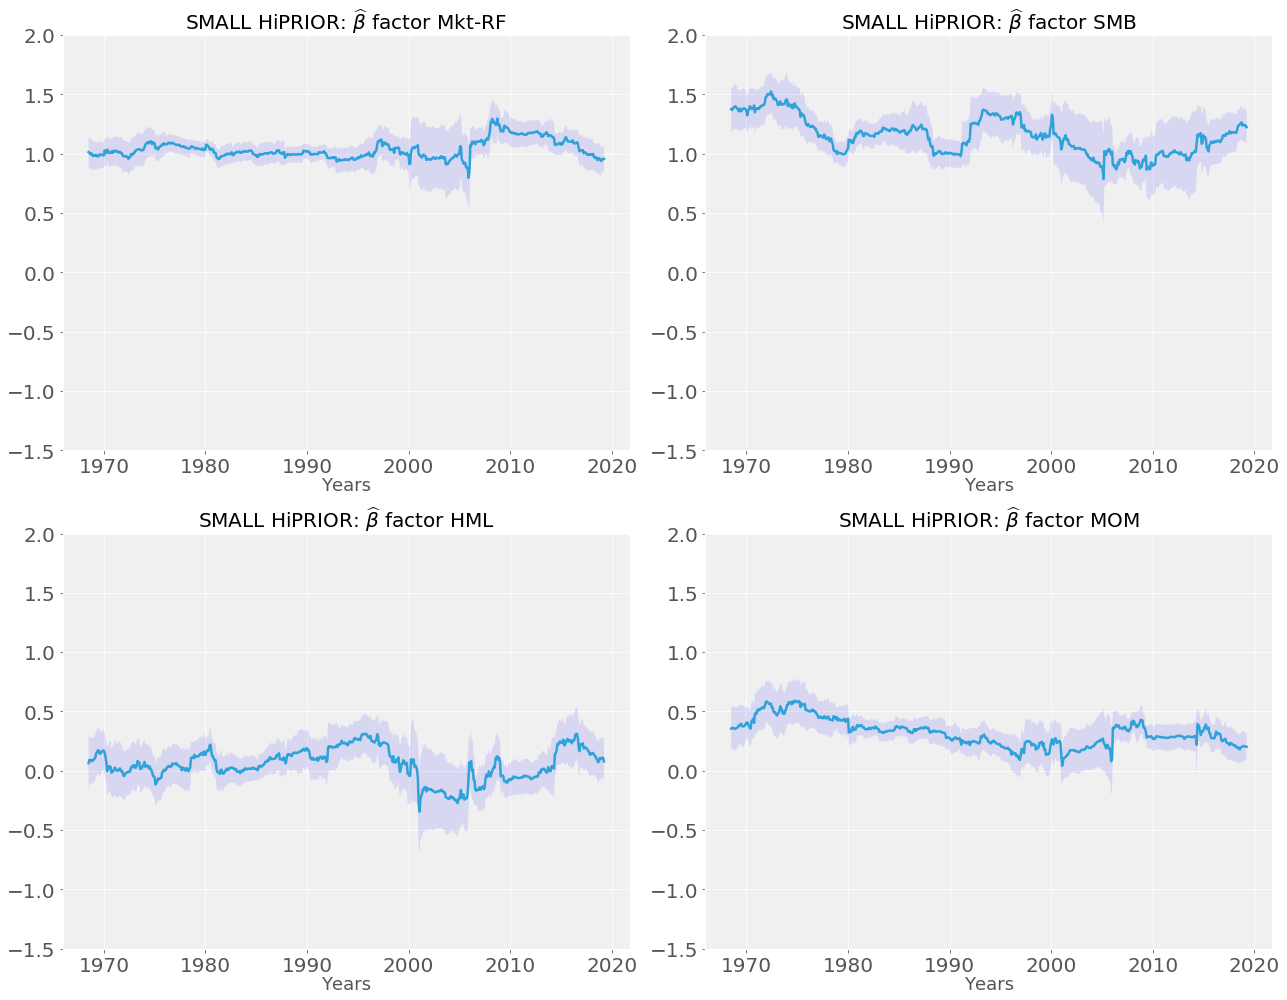

In [391]:
port_name = 'SMALL HiPRIOR'
plot_roll_beta(Y0=Rex_test[port_name], X0=Factors_ret, window=roll_window, cov_type='HC0',
               port_name=port_name)


### Corner portfolio #3: `BIG LoPRIOR`

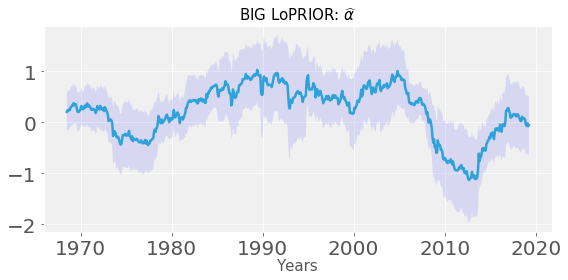

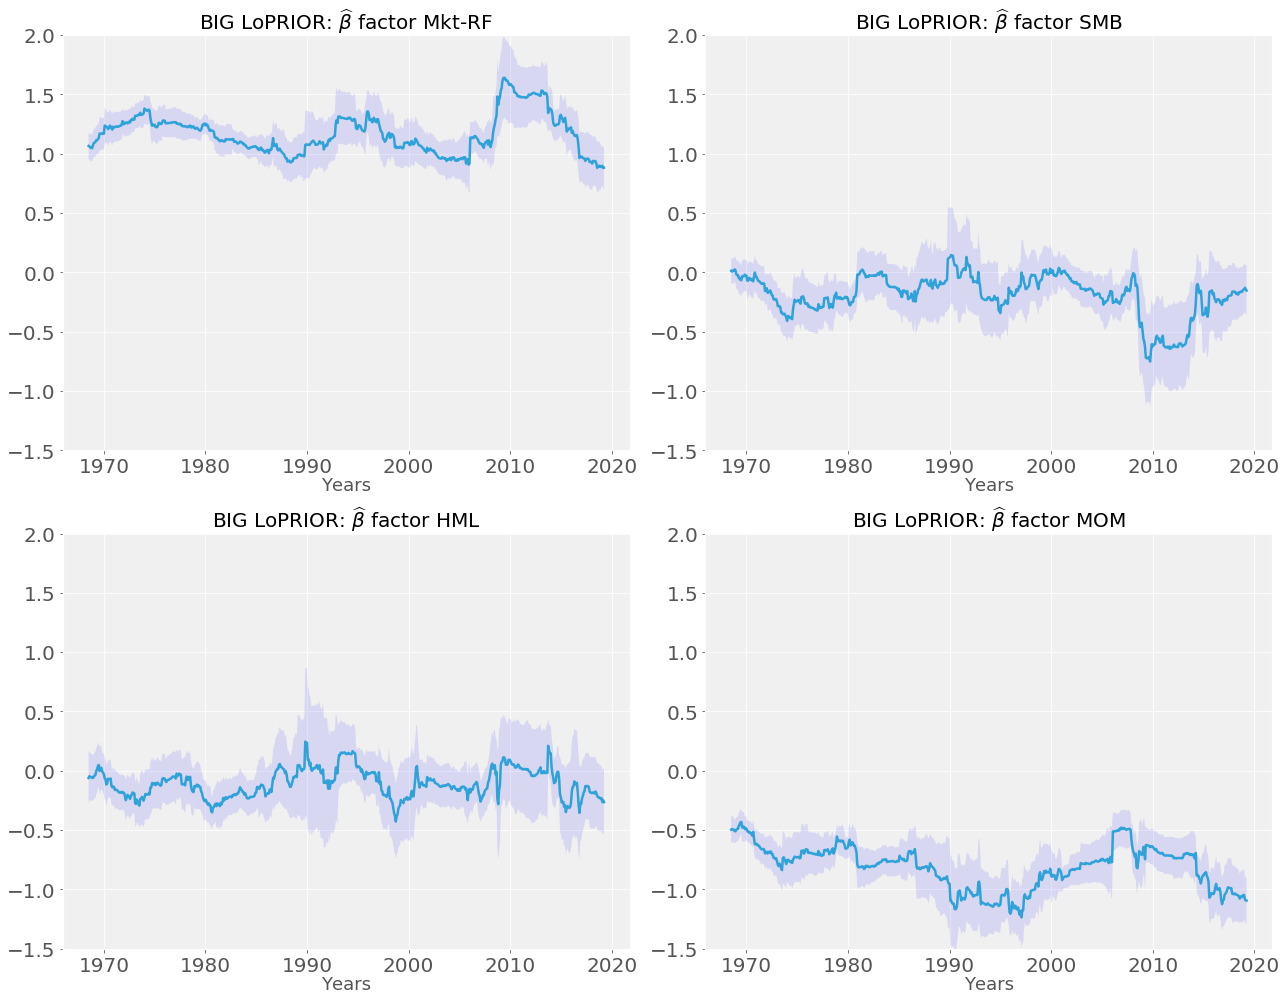

In [392]:
port_name = 'BIG LoPRIOR'
plot_roll_beta(Y0=Rex_test[port_name], X0=Factors_ret, window=roll_window, cov_type='HC0', 
               port_name=port_name)


### Corner portfolio #4: `BIG HiPRIOR`

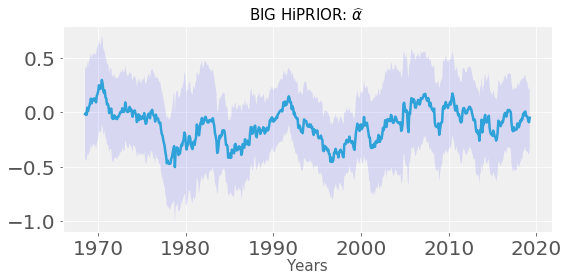

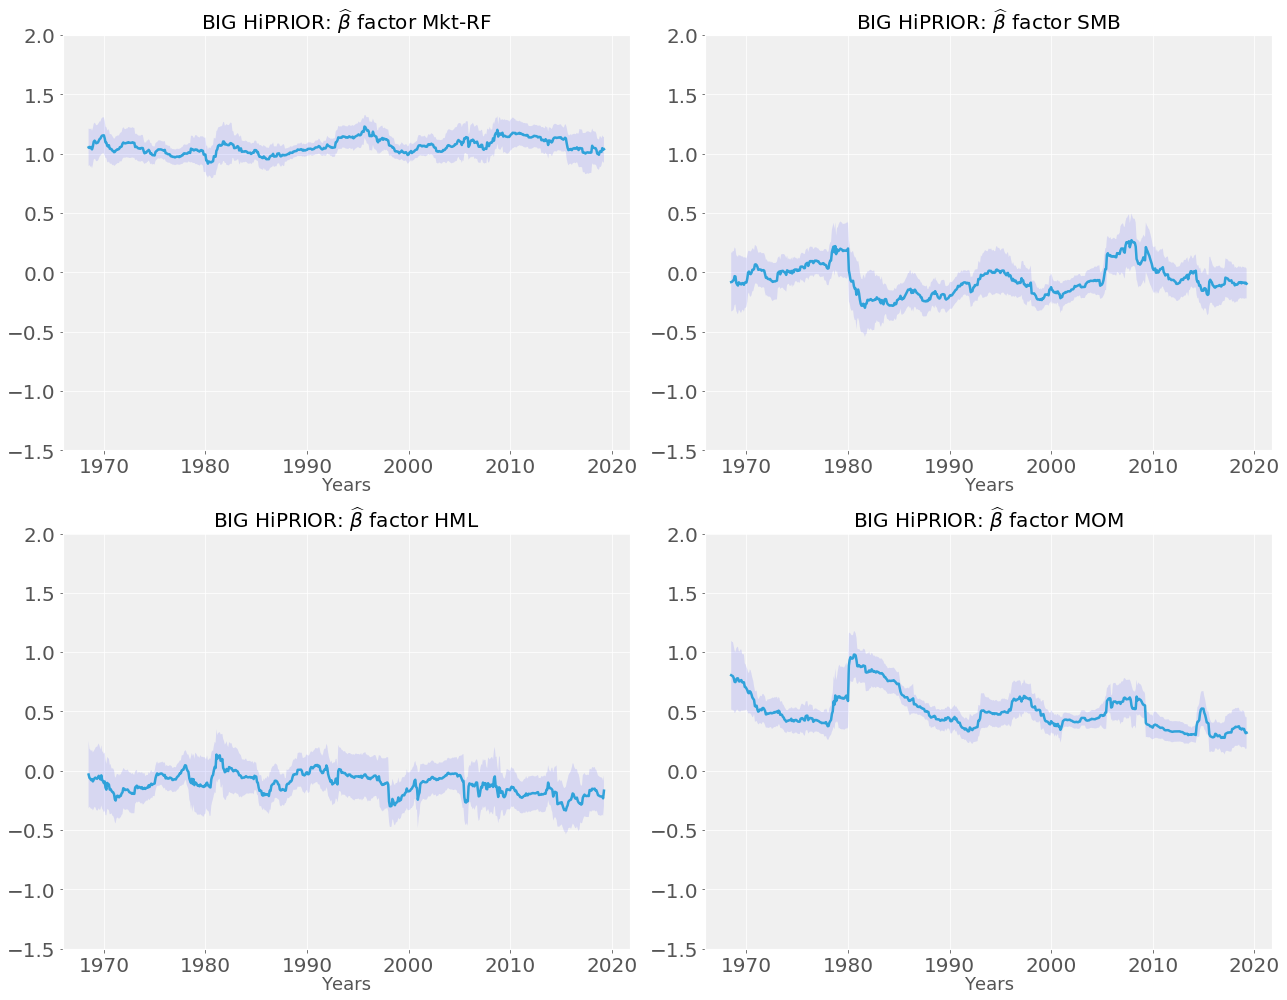

In [393]:
port_name = 'BIG HiPRIOR'
plot_roll_beta(Y0=Rex_test[port_name], X0=Factors_ret, window=roll_window, cov_type='HC0', 
               port_name=port_name)


# Exercise 8:
Repeat **Exercise 6** using the **Fama-MacBeth (1973)** estimation method and compare the results to those from that question.

The Fama-MacBeth procedure is related to the rolling regressions from the previous exercise. In a nutshell, the idea is to recursively estimate the betas $\beta_t$ and then run a **cross-sectional** regression every period using the estimated $\beta_t$. 

#### Step 1: 
Start at the beginning of the sample and use the first 60 observations (i.e months) to estimate a **time-series regression** that provides estimate $\widehat{\beta}_{60,i}$:

$$
 R_{i,t}^{e} = \widehat{a}_i + \widehat{\beta}_{60,i} F_{1, t} + ... + \widehat{\beta}_{60,K} F_{K, t} +\epsilon_{i,t}, \;\text{for } t=1,2,...,60
$$

#### Step 2:
Estimate a **cross-sectional regression** for period $t=61$:

$$
 R_{i,61}^{e} = \left(\lambda_{0,61}\right) + \lambda_{1,61} \widehat{\beta}_{60,1} + ... +  \lambda_{K,61} \widehat{\beta}_{60,K} + \alpha_{61}
$$

where we define the estimated vector $\widehat{\lambda}_{61} = (\widehat{\lambda}_{0,61}, \widehat{\lambda}_{1,61})^{\prime}$ if we include the constant $\lambda_{0,61}$ in the **XS** regression. 

We repeat **Steps 1** and **2** by shifting the sample forward one month to estimate $\{\beta_{61,i}\}_{i=1}^{K}$, $\alpha_{62}$, and $\lambda_{61}$. 

We repeat until we reach the end of the sample, thus obtaining the time series of estimates $\{\widehat{\alpha}_{t}\}_{t=61}^{T}$ and $\{\widehat{\lambda}_{t}\}_{t=61}^{T}$

The risk premium is estimated using the time-series mean of the estimates $\{\widehat{\lambda}_{t}\}_{t=61}^{T}$:

$$
 \widehat{\lambda} = \frac{1}{(T-59)} \sum_{t=61}^{T}  \widehat{\lambda_t} 
$$

with **variance-covariance** matrix (under the assumption of no autocorrelation): 

$$
 \mathbf{Var}\left(\widehat{\lambda}\right) = \frac{1}{(T-59)^{2}} \sum_{t=61}^{T}  \left(\widehat{\lambda_t} -\widehat{\lambda}\right)\left(\widehat{\lambda_t} -\widehat{\lambda}\right)^{\prime}
$$

Similarly, for the pricing errors $\widehat{\alpha}_t$,

$$
 \widehat{\alpha} = \frac{1}{(T-59)} \sum_{t=61}^{T}  \widehat{\alpha_t} 
$$

with **variance-covariance** matrix (under the assumption of no autocorrelation): 

$$
 \mathbf{Var}\left(\widehat{\alpha}\right) = \frac{1}{(T-59)^{2}} \sum_{t=61}^{T}  \left(\widehat{\alpha_t} -\widehat{\alpha}\right)\left(\widehat{\alpha_t} -\widehat{\alpha}\right)^{\prime}
$$

The $\chi^2$ test statistic under the null hypothesis $\mathbf{H}_0:\alpha_1=...\alpha_N=0$ is given by: 

$$
\widehat{\alpha}^{\prime}\cdot  \mathbf{Var}\left(\widehat{\alpha}\right)^{-1} \cdot \widehat{\alpha}\sim \chi^2_{\left(N-K-1\right)}
$$



In [443]:
def fama_macbeth_roll(Y0, X0, addcon_ts=True, addcon_xs=True, window=60):       
    
    x0 = np.asarray(X0)
    y0 = np.asarray(Y0) 
    if y0.ndim==2:
        Nests = y0.shape[0] - window
        N = y0.shape[1]
        K = x0.shape[1]
        x = [(x0[i:i + window,:]) for i in range(Nests)]
        if N >= K:        
            y = [(y0[i:i+window,:]) for i in range(Nests)]
            y_lead = [(y0[i+window:i+window+1,:]) for i in range(Nests)]
        else:    
            raise IndexError('\nException: UnderIdentificationError:\nYou have less observations than factors!')
    else: 
        raise IndexError('\nException: UnderIdentificationError:\nYou have less observations than factors!')

    ### Step 1: time-series regressions (beta)
    if addcon_ts:
        ols_r = [sm.OLS(y[j], sm.add_constant(x[j])).fit(cov_type='nonrobust') for j in range(len(x))]
        beta_hat= np.asarray([ols_r[j].params[1:] for j in range(len(ols_r))]) 
    else:   
        ols_r = [sm.OLS(y[j], x[j]).fit(cov_type='nonrobust') for j in range(len(x))]
        beta_hat= np.asarray([ols_r[j].params for j in range(len(ols_r))])     

    ### Step 2: cross-sectional regressions (lambda, alphas)
    if addcon_xs:
        ols_r_lead = [sm.OLS(y_lead[i].T, sm.add_constant(beta_hat[i].T)).fit(cov_type='nonrobust') 
                      for i in range(Nests)]
    else:   
        ols_r_lead = [sm.OLS(y_lead[i].T, beta_hat[i].T).fit(cov_type='nonrobust') for i in range(Nests)]
        
    lambda_hat_roll = np.asarray([ols_r_lead[i].params for i in range(Nests)])        
    alpha_hat_roll  = np.asarray([ols_r_lead[i].resid for i in range(Nests)]) 

    lambda_hat = np.mean(lambda_hat_roll, axis=0)
    alpha_hat  = np.mean(alpha_hat_roll, axis=0)

    ### Sampling errors:
    var_alpha  = (T**-2)*np.dot(alpha_hat_roll.T  - alpha_hat[:,None],  alpha_hat_roll - alpha_hat[:,None].T)
    var_lambda = (T**-2)*np.dot(lambda_hat_roll.T - lambda_hat[:,None], lambda_hat_roll - lambda_hat[:,None].T)

    ### Standard error of lambda, alphas
    se_alpha_hat  = var_alpha.diagonal()**0.5
    se_lambda_hat = var_lambda.diagonal()**0.5

    ### chi-squared, test-statistic  
    dof = N - K - 1
    fama_macbeth_chi2_tstat = np.dot(np.dot(alpha_hat.T, np.linalg.inv(var_alpha)), alpha_hat)
    fama_macbeth_pval = 1 - chi2.cdf(fama_macbeth_chi2_tstat, dof)

    print('(Fama-MacBeth, 1973) chi-squared test statistic: ', round(fama_macbeth_chi2_tstat, 3))
    print('(Fama-MacBeth, 1973) p-value: ', round(fama_macbeth_pval, 3))
    print('\tThe 95% critical value of Chi-squared distribution is:', round(chi2.ppf(0.95, dof), 3))
    if fama_macbeth_chi2_tstat > chi2.ppf(0.95, dof):
        print('\tWe reject the null hypothesis that the pricing errors are jointly zero.\n')
    else:
        print('\tWe fail to reject the null hypothesis that the pricing errors are jointly zero.\n')
    
    if addcon_xs:
        f_list = ['$\lambda_{0}$'] + list(X0.columns)
    else:
        f_list = list(X0.columns)
    
    df_lambda_hat = pd.DataFrame(index=f_list, columns=['$\widehat{\lambda}$',
                                                        '$SE(\widehat{\lambda})_{OLS}$', 'Factor premium'])    
    df_alpha_hat  = pd.DataFrame(index=Y0.columns, 
                                 columns=['$\widehat{\\alpha}$',
                                          '$SE(\widehat{\\alpha})_{OLS}$'])
    
    df_lambda_hat['$\widehat{\lambda}$'] = lambda_hat
    df_lambda_hat['$SE(\widehat{\lambda})_{OLS}$'] = se_lambda_hat
    df_lambda_hat['Factor premium'] = X0.mean()
    
    df_alpha_hat['$\widehat{\\alpha}$'] = alpha_hat
    df_alpha_hat['$SE(\widehat{\\alpha})_{OLS}$'] = se_alpha_hat

    fama_macbeth_results = {'Number of estimates': Nests, 
                            'Test Assets/Portfolios': N, 
                            'Total Factors': K, 
                            'df_lambda': df_lambda_hat, 
                            'df_alpha': df_alpha_hat}
    
    return fama_macbeth_results


In [444]:
def create_alpha_table(df_alpha, Rex_test_name):
    
    if Rex_test_name=='SIZE_BM':
        rows_idx = ['SMALL', 'ME2', 'ME3', 'ME4', 'BIG']
        cols_idx = ['LoBM', 'BM2', 'BM3', 'BM4', 'HiBM']
    elif Rex_test_name=='SIZE_MOM':
        rows_idx = ['SMALL', 'ME2', 'ME3', 'ME4', 'BIG']
        cols_idx = ['LoPRIOR', 'PRIOR2', 'PRIOR3', 'PRIOR4', 'HiPRIOR']        
    df_alphas_rect    = pd.DataFrame(index=rows_idx, columns=cols_idx)  
    df_alphas_se_rect = pd.DataFrame(index=rows_idx, columns=cols_idx)  
    
    for i in df_alpha.index:   
        row, col = i.split()[0], i.split()[1]
        if Rex_test_name=='SIZE_BM':
            if row=='ME1': row = 'SMALL' 
            if row=='ME5': row = 'BIG' 
            if col=='BM1': col = 'LoBM' 
            if col=='BM5': col = 'HiBM' 
        elif Rex_test_name=='SIZE_MOM':      
            if row=='ME1': row = 'SMALL' 
            if row=='ME5': row = 'BIG' 
            if col=='PRIOR1': col = 'LoPRIOR' 
            if col=='PRIOR5': col = 'HiPRIOR'                
        df_alphas_rect.at[row, col]   = df_alpha.at[i, '$\widehat{\\alpha}$'] 
        df_alphas_se_rect.at[row, col] = df_alpha.at[i, '$SE(\widehat{\\alpha})_{OLS}$'] 
        
    #--> alphas
    df_alphas_rect = pd.concat([df_alphas_rect], axis=1, keys=['$\widehat{\\alpha}$'])
    alpha_tab = multi_table([df_alphas_rect])
    
    #--> alphas SEs (OLS)
    df_alphas_se_rect = pd.concat([df_alphas_se_rect], axis=1, keys=['$SE(\widehat{\\alpha})_{OLS}$'])
    alpha_se_tab = multi_table([df_alphas_se_rect])
    
    return alpha_tab, alpha_se_tab

Let's first run the **Fama-MacBeth** estimation and testing procedure without imposing a constant in the cross-sectional regression: 

In [445]:
Rex_test = Rex_SIZE_MOM
Factors_ret = df_SIZE_MOM[['Mkt-RF', 'SMB', 'HML', 'MOM']]
roll_window = 60


In [446]:
ff4_fama_macbeth_nocon_results = fama_macbeth_roll(Y0=Rex_test, 
                                             X0=Factors_ret, 
                                             addcon_ts=True, 
                                             addcon_xs=False,
                                             window=roll_window)

(Fama-MacBeth, 1973) chi-squared test statistic:  150.618
(Fama-MacBeth, 1973) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 31.41
	We reject the null hypothesis that the pricing errors are jointly zero.



Pricing errors $\widehat{\alpha}_i$ (w/out constant in **XS** regression):

In [447]:
df_alpha = ff4_fama_macbeth_nocon_results['df_alpha']
Rex_test_name = 'SIZE_MOM'

alpha_tab, alpha_se_tab = create_alpha_table(df_alpha, Rex_test_name=Rex_test_name)

In [448]:
display(alpha_tab)

In [449]:
 display(alpha_se_tab)

Prices of risk $\widehat{\lambda}_j$ (w/out constant in **XS** regression):

In [450]:
ff4_fama_macbeth_nocon_results['df_lambda'].T

,Mkt-RF,SMB,HML,MOM
$\widehat{\lambda}$,0.559,0.171,0.232,0.635
$SE(\widehat{\lambda})_{OLS}$,0.182,0.126,0.155,0.175
Factor premium,0.530,0.240,0.312,0.652


Now, let's include a constant in the cross-sectional regression: 

In [451]:
ff4_fama_macbeth_con_results = fama_macbeth_roll(Y0=Rex_test, 
                                             X0=Factors_ret, 
                                             addcon_ts=True, 
                                             addcon_xs=True,
                                             window=roll_window)

(Fama-MacBeth, 1973) chi-squared test statistic:  217.499
(Fama-MacBeth, 1973) p-value:  0.0
	The 95% critical value of Chi-squared distribution is: 31.41
	We reject the null hypothesis that the pricing errors are jointly zero.



Pricing errors $\widehat{\alpha}_i$ (w/ constant in **XS** regression):

In [452]:
df_alpha = ff4_fama_macbeth_con_results['df_alpha']
Rex_test_name = 'SIZE_MOM'

alpha_tab, alpha_se_tab = create_alpha_table(df_alpha, Rex_test_name=Rex_test_name)

In [453]:
display(alpha_tab)

In [454]:
 display(alpha_se_tab)

Prices of risk $\widehat{\lambda}_j$ (w/ constant in **XS** regression):

In [455]:
ff4_fama_macbeth_con_results['df_lambda'].T

,$\lambda_{0}$,Mkt-RF,SMB,HML,MOM
$\widehat{\lambda}$,0.968,-0.354,0.138,-0.089,0.611
$SE(\widehat{\lambda})_{OLS}$,0.238,0.274,0.125,0.157,0.175
Factor premium,nan,0.530,0.240,0.312,0.652


# Exercise 9:
Compute the standard errors in **Exercise 6** that correct for the fact that the beta's are estimated in the first stage.  This is known as the **Shanken-correction**.  The correction is derived in the Appendix of the lecture notes.  

**Chapter 12 of Cochrane's `Asset Pricing`** book has further details of the **2-stage estimation**.

## Solution to Exercise 9: (TO BE COMPLETED)

That is all for today! 😎